# t-closeness analysis for comscore panel data, stratified by income x race


In [231]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from style_config import BLUE
from utils.data import  race_groups as race_values, income_groups_4 as collapsed_income_values

## Set up the data

The cohorts have already been computed for 520 panels generated via a random stratified sampling process.
The strata were defined by individuals' income x race demographic categories.

Here we analyze those panels w.r.t. t-closeness, where the sensitive categories are defined by the income and race categories.


We created one set of panels stratified on both income and race.
However, we analyze the income and race categories separately.



In [144]:
# values of t to evaluate
T_increments = 0.005
T_max = 0.5
T = np.arange(0, T_max+T_increments, T_increments) 
## Demographic mappings
# race_values
collapsed_income_values.update({'any':'any'})
print('t values:\n', T)

t values:
 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5  ]


### Read in the panel and (true) cohorts data.

In [5]:
panels_cohorts_fpath = '../output/comscore_cps_income_race_panels_cohorts.csv'

all_panels_cohort_df = pd.read_csv(panels_cohorts_fpath)
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

## t-closeness analysis functions


### Binomial distribution

Estimating expected t-closeness violations with a binomial distribution.


Definition borrowed from wikipedia: https://en.wikipedia.org/wiki/Binomial_distribution#Probability_mass_function

In general, if the random variable $X$ follows the binomial distribution with parameters $n \in {\displaystyle \mathbb {N} }$  and $p \in [0,1]$, we write $X$ ~ $B(n, p)$. The probability of getting exactly $k$ successes in $n$ independent Bernoulli trials is given by the probability mass function:

${\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}}{\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}}$

for k = 0, 1, 2, ..., n, where

${\displaystyle {\binom {n}{k}}={\frac {n!}{k!(n-k)!}}}$

is the binomial coefficient.


### Cumulative Distribution Function (CDF)

The CDF can be expressed as:

${\displaystyle F(k;n,p)=\Pr(X\leq k)=\sum _{i=0}^{\lfloor k\rfloor }{n \choose i}p^{i}(1-p)^{n-i},}{\displaystyle F(k;n,p)=\Pr(X\leq k)=\sum _{i=0}^{\lfloor k\rfloor }{n \choose i}p^{i}(1-p)^{n-i}}$


#### How we use binomial distributions

Consider one target t, and one race at a time. 

Use average cohort size as n.
Consider a "success" as drawing the demographic category for a cohort.
$p$ is then the fraction of the category in the population.

Set k such that k would violate t-closeness.

What is the probability of exceeding k? Can we compute this using the binomial CDF?


$1 - F(k, n, p) $?

This represents the expected fraction of cohorts that will violate t-closeness for a given t.

In [15]:
from scipy.stats import binom


def estimate_prob_t_closeness_violation_binomial(n, p, t):
    """
    Returns estimated expected fraction of cohorts that 
    violate t-closeness
    
    Where this is estimated by a bionomial distribution
    
    n represents cohort size (mean cohort size) for all panels
    p represents probability of drawing from category
    t is t value for t-closeness
    """
    k = n * (p + t)
    return 1 - binom.cdf(k, n, p)

First, we create a table representing $p$ for each category: the underlying, marginal distribution for each demographic category in our cohorts — this is really just the Census estimated marginal distribution on the demographic group. 
We need to set $n$, the population size, for our binomial simulation, so we calculate the average cohort size across our panels:

Using the binomial CDF, we calculate the expected t-closeness violations by t value and race category. These values can be directly compared to the empirical data we've computed to test whether we see more t-closeness violations than we expect given population sizes.

In [107]:
def get_est_t_violations_df(proportion_kvs, n, T=T):
    """
    Returns a dataframe with estimated t-closeness violations
    for each t in T, corresponding to the passed proportions.
    Estimations use a binomial CDF.
    
    n: (avg) cohort size
    
    proportion_kvs: an interable that returns tuples (name, p)
        where p values represent the portion of name in the
        overall population and sum to 1.
    """
    df = pd.DataFrame({'t': T})
    for (name, p) in proportion_kvs:
        est = lambda t: estimate_prob_t_closeness_violation_binomial(n, p, t)
        df[name] = df['t'].apply(est)
    return df.set_index('t')

In [16]:
# Calcualte average cohort and panel sizes for 
# generating binomial distribution (used for both income and race analysis)
panel_sizes = (all_panels_cohort_df
               .groupby('panel_id')
               .size()
               .rename('panel_size')
               .to_frame())

panel_sizes['avg_cohort_size'] = (all_panels_cohort_df
                                .groupby(['panel_id', 'cohort'])
                                .size()
                                .rename('size')
                                .reset_index()
                                .groupby(['panel_id'])
                                .agg({'size': [np.mean]}))
panel_sizes.head()

panel_size  avg_cohort_size
panel_id                             
1              23250        49.050633
2              23209        47.172764
3              23831        50.170526
4              22897        50.323077
5              23761        48.690574

In [104]:
# get approximation of n in the binominial distribution
n = round(np.mean(panel_sizes.avg_cohort_size))
print('n = %s' % n)

n = 49


## Analysis by income and race separately

We do the same kind of analysis for the income groups separately from the racial background groups. 

In each analysis, we use the same panels and therefore same sets of cohorts in analysis. However, in each case we are either analyzing the income group or race group distributions tied to the cohorts.

First we show what results would look like if we only had a single panel, and therefore just computed t-closeness violations for this one panel, where cohorts were computed for k=30.

In [215]:
# some helper functions for plotting
import math

t = 0.1

race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
collapsed_income_code_values = {
    1:'less than $25,000',
    2:'\$25,000 - $75,000',
    3:'\$75,000 - $150,000',
    4:'\$150,000 or more'
}

def get_cohort_demo_portions_df(panel_df, demo_col, cohort_name='cohort'):
    df = panel_df.groupby(
        [cohort_name, demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby(cohort_name).count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df


def plot_cohort_demo_fractions(panel_df, demo_col, demo_value_names_dict, 
                               cohort_name='cohort', 
                               ncols=4, print=False, dpi=100):
    
    nrows = math.ceil(len(demo_value_names_dict)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), dpi=dpi)
    axes = axes.flatten()
    axes[0].set_ylabel('fraction')
    fig.tight_layout()

    cohort_demo_portions_df = get_cohort_demo_portions_df(
        panel_df, demo_col, cohort_name=cohort_name)
    demo_fractions = panel_df.groupby(demo_col)['panel_id'].count() / len(panel_df)
    
    for i, (val,name) in enumerate(demo_value_names_dict.items()):
        ax = axes[i]
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        if print:
            print('mean fraction %s across cohorts = %0.2f' % (name, cohort_demo_mean))
            print('fraction %s across all users in cohorts = %0.2f' % (name, demo_fraction))
        cohort_demo_portions_df[
            (cohort_demo_portions_df[demo_col]==val)
        ].portion.sort_values(ascending=False).plot.bar(
            ax=ax, label="", color=BLUE,
        )
        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        ax.set_title(name.capitalize())
    plt.show()
    return cohort_demo_portions_df

### Race Analysis

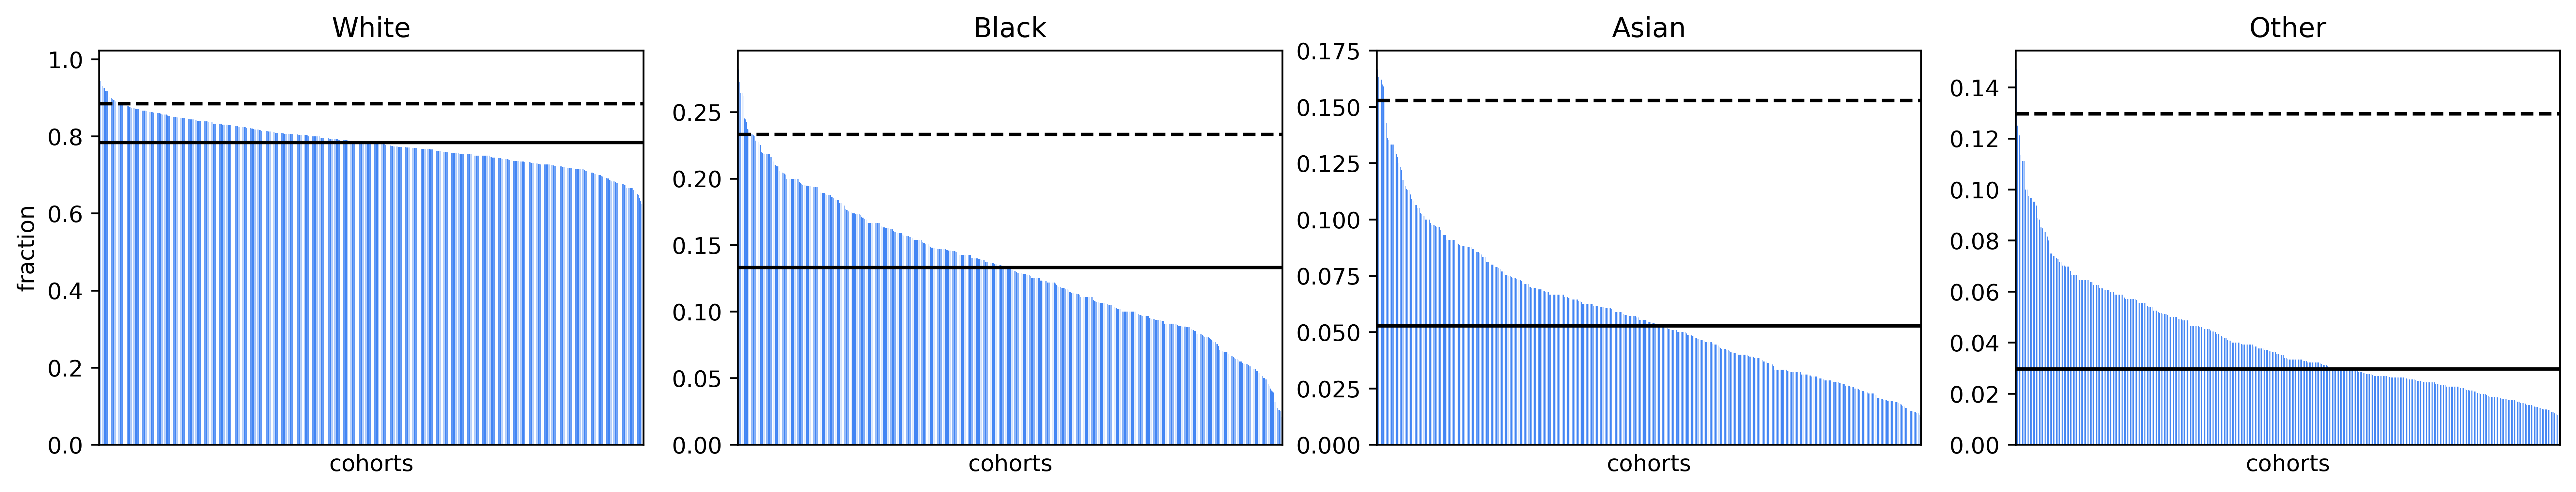

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

In [219]:
example_panel_id = 1
example_panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==1]

_ = plot_cohort_demo_fractions(example_panel_df, 'racial_background', 
                               race_values, cohort_name='cohort', dpi=500)
example_panel_df.head()

Luckily we have 520 panels (corresponding to 52 weeks x 10 panels per week).
This allows us to compute mean t-closeness violations with confidence intervals, for ranging values of t.
Furthermore, we might expect t-closeness violations due to random chance.

Now we move on to doing the main analysis work that computes t-closeness for all panels and compares the empirical results to what would be expected from the described simulations/use of binomial CDFs.


In [18]:
# Compute underlying race probabilities
race_fractions_df = (
    all_panels_cohort_df.groupby('racial_background').size()/len(all_panels_cohort_df)
).rename('fraction').to_frame()
race_fractions_df['race'] = race_fractions_df.index.map(race_values)
race_fractions_df

fraction   race
racial_background                 
1.0                0.784348  white
2.0                0.133265  black
3.0                0.052798  asian
5.0                0.029589  other

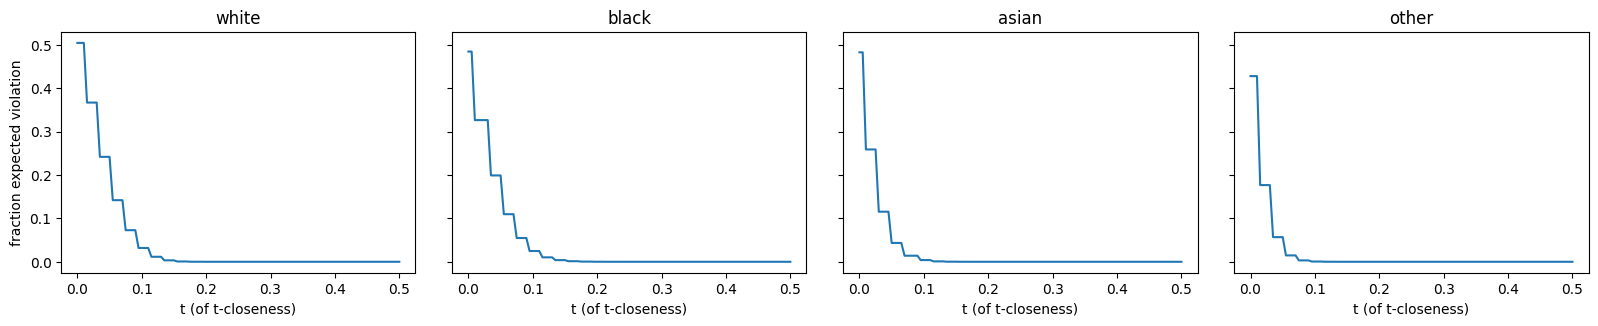

In [108]:
# calculate estimated violations for each t

est_t_violations_df = get_est_t_violations_df(
    race_fractions_df.set_index('race')['fraction'].items(),
    n,
)
fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
plt.tight_layout()
for i, cat in enumerate(est_t_violations_df.columns):
    ax = axes[i]
    ax.plot(est_t_violations_df[cat])
    ax.set_title(cat)
    ax.set_xlabel('t (of t-closeness)')
    
_ = axes[0].set_ylabel('fraction expected violation')

# Plotting binomial simulation against empirical data

In [20]:
def aggregate_t_closeness_violations(df, 
                                     demo_col='racial_background',
                                     values_map=race_values):
    return (df
        .groupby(['t', demo_col])
        .agg({'fraction_violate': [np.mean, 
               lambda x: np.mean(x) + 1.96*np.std(x),
               lambda x: np.mean(x) - 1.96*np.std(x)]})
        .set_axis(['fraction_violate', 'upper', 'lower'], axis=1, inplace=False)
        .reset_index()
)

In [66]:
def get_cohort_demo_fractions_df(panel_df, cohort_name='cohort', 
                                demo_col='racial_background'):
    """
    Returns a dataframe with columns
    cohort, demo_col, count, total, fraction
    """
    df = panel_df.groupby(
        [cohort_name, demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby(cohort_name).count()['panel_id']
    df['fraction'] = df['count']/df['total']
    return df


def calculate_violates(df, t, demo_fractions, 
                         demo_col='racial_background'):
    """
    Calculates for each cohort in `df` whether t-closeness
    is violated for given t.
    
    This is true when the cohort population's frequency
    for a category is at least `t` greater than the base 
    population frequency.
    
    Each row in `df` is a cohort.
    """
    return (df
          .assign(population_fraction = lambda x: x[demo_col].map(demo_fractions))
          .assign(t = lambda x: x.fraction - x.population_fraction)
          .assign(violate = lambda x: x.t >= t))


def calculate_fraction_violate(panel_df, t, demo_col='racial_background',
                              cohort_name='cohort'):
    cohort_demo_fractions_df = get_cohort_demo_fractions_df(
        panel_df, cohort_name=cohort_name, demo_col=demo_col
    )
    demo_fractions = panel_df.groupby(
        demo_col
    )['panel_id'].count() / len(panel_df)
    any_violated = (cohort_demo_fractions_df
     .pipe(calculate_violates, t=t, demo_fractions=demo_fractions, demo_col=demo_col)
     .reset_index()
     .assign(n_cohorts = lambda x: x[cohort_name].nunique())
     .groupby(cohort_name)
     .agg({'violate': lambda x: sum(x) > 0})
                    ).pipe(lambda df: df.violate.sum() / len(df))
    any_violate_df = pd.DataFrame({demo_col: ['any'],
                                 'fraction_violate': [any_violated],
                                 't': [t]})
    return (cohort_demo_fractions_df
            .pipe(calculate_violates, t=t, demo_fractions=demo_fractions, demo_col=demo_col)
            .reset_index()
            # calculate fraction of cohorts, grouped by demo, that violate for t.
            .assign(n_cohorts = lambda x: x[cohort_name].nunique())
            .groupby([demo_col])
            .apply(lambda x: sum(x.violate) / x.n_cohorts)
            .reset_index()
            # becuase we use `apply` above, drop duplicates to get only demo_col, fraction_violates
            [[demo_col, 'n_cohorts']]
            .drop_duplicates()
            .rename(columns={'n_cohorts': 'fraction_violate'})
            .reset_index(drop=True)
            .assign(t=t)
            # then, concatenate with our any_violate_df with a demo_col of `any`
            ).pipe(lambda df: pd.concat([df, any_violate_df]))


def panel_t_closeness(panel_df, demo_col='racial_background',
                      cohort_name='cohort', T=T):
    """
    Calculates t-closeness violations for a range of t values for a 
    given demographic column and panel dataframe.
    
    Returns a dataframe with the following columns
        demo_col, fraction_violate, t
    """
    return pd.concat(
        [calculate_fraction_violate(panel_df, demo_col=demo_col, cohort_name=cohort_name, t=t) for t in T]
    )

def panels_t_closeness(panels_df, demo_col='racial_background',
                       cohort_name='cohort', T=T, panel_ids=None):
    if panel_ids is None:
        panel_ids = panels_df.panel_id.unique()
    print('computing t-closeness for %s panels' % (len(panel_ids)))
    panels = [panels_df[panels_df.panel_id == panel_id] for panel_id in panel_ids]
    t_closeness_dfs = [panel_t_closeness(panel, demo_col=demo_col, cohort_name=cohort_name, T=T).assign(panel_id=panel_id) for panel, panel_id in zip(panels, panel_ids)]
    return pd.concat(t_closeness_dfs)


In [67]:
all_panels_cohort_df.head(3)

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8

In [ ]:
start_time = datetime.now()
print('%s - computing t-closeness for all panels' % start_time)
all_panels_t_closeness_df = panels_t_closeness(
    all_panels_cohort_df
)
end_time = datetime.now()
time = end_time - start_time
print('%s - time: %s' % (end_time, time))
all_panels_t_closeness_df.head()

In [24]:
# align and merge simulated and empirical data

agg_t_closeness_df = aggregate_t_closeness_violations(
    all_panels_t_closeness_df,
    demo_col='racial_background', values_map=race_values
)
agg_t_closeness_df['race'] = agg_t_closeness_df['racial_background'].map(race_values)

simulated_violations_df = (est_t_violations_df
 .reset_index()
 .melt(id_vars=['t'], 
       var_name='race', 
       value_name='fraction_violate')
 .assign(kind='Simulated')
)

plot_df = pd.concat([simulated_violations_df,
                    (agg_t_closeness_df
                     .assign(kind='Empirical')
                     .drop('racial_background', axis=1))])

In [25]:
plot_df.kind.unique()

array(['Simulated', 'Empirical'], dtype=object)

In [26]:
plot_df.head()

t   race  fraction_violate       kind  upper  lower
0  0.000  white          0.504053  Simulated    NaN    NaN
1  0.005  white          0.504053  Simulated    NaN    NaN
2  0.010  white          0.504053  Simulated    NaN    NaN
3  0.015  white          0.366606  Simulated    NaN    NaN
4  0.020  white          0.366606  Simulated    NaN    NaN

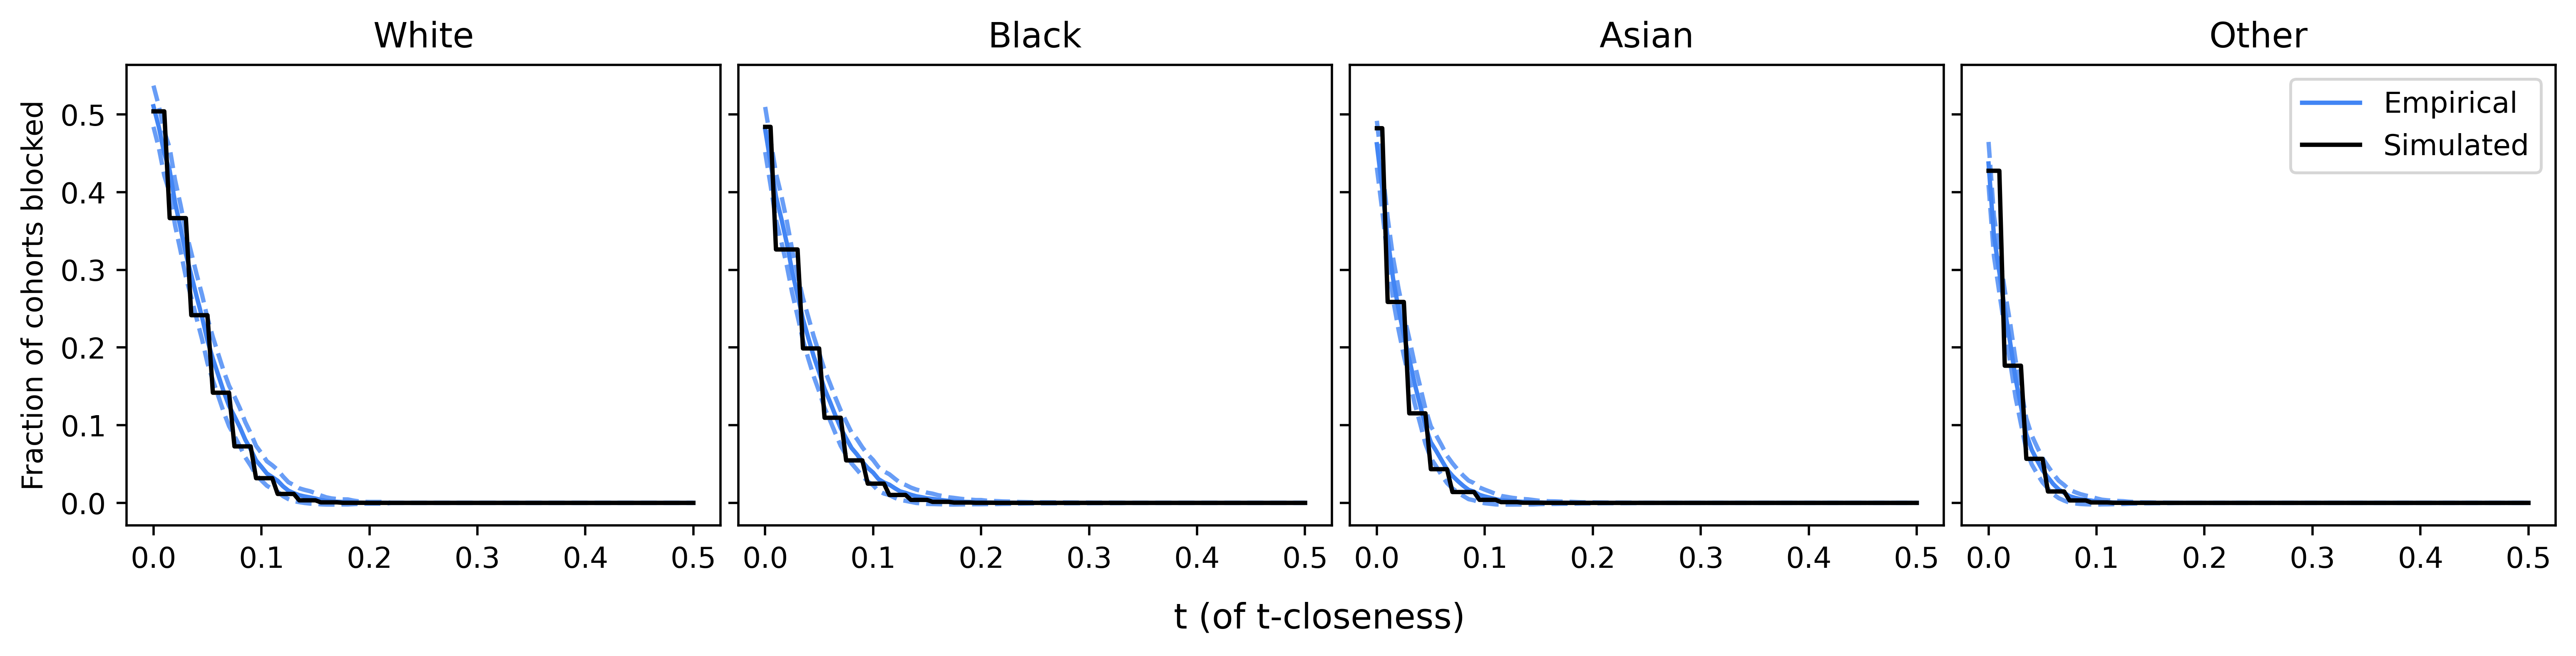

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(4*3.1, 2.8), dpi=500, sharey=True, sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)
for i, cat in enumerate(est_t_violations_df.columns):
    ax = axes[i]
    emp_df = plot_df[(plot_df.race==cat) & (plot_df.kind == 'Empirical')].set_index('t')
    ax.plot(emp_df.lower, '--', alpha=0.8, color=BLUE)
    ax.plot(emp_df.upper, '--', alpha=0.8, color=BLUE)
    ax.plot(emp_df.fraction_violate, color=BLUE, label='Empirical')
    sim_df = plot_df[(plot_df.race==cat) & (plot_df.kind == 'Simulated')].set_index('t')
    ax.plot(sim_df.fraction_violate, color='black', label='Simulated')
    ax.set_title(cat.capitalize())
    

fig.text(0.5, -0.04, 't (of t-closeness)', fontsize='large', ha='center', color='black')
_ = axes[0].set_ylabel('Fraction of cohorts blocked')
_ = ax.legend()

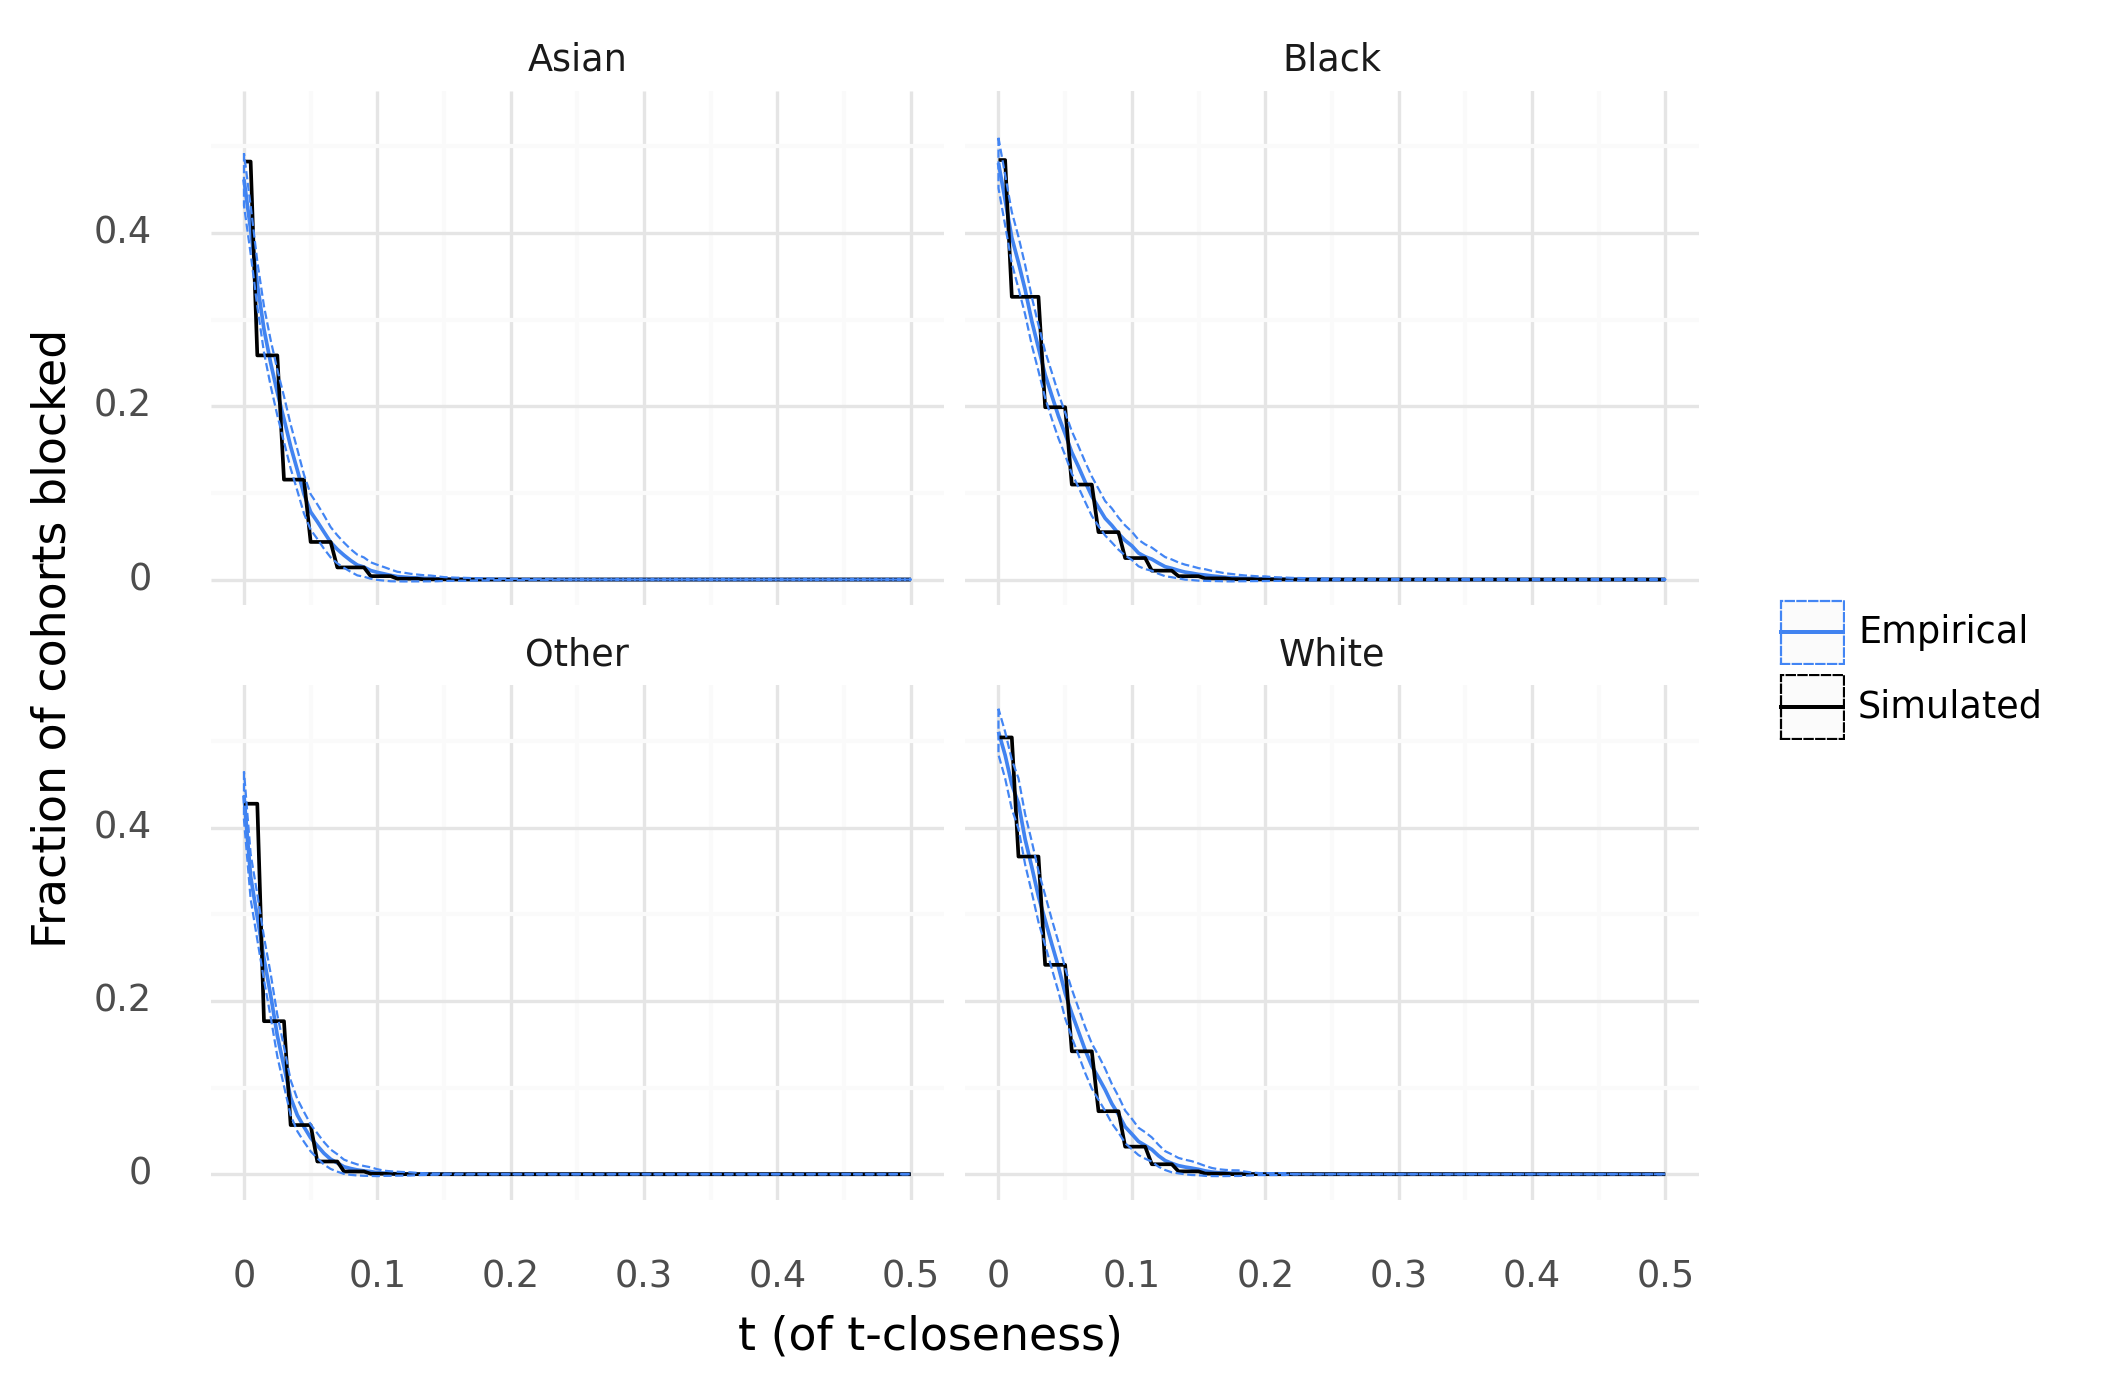

<ggplot: (8788015792125)>

In [28]:
from plotnine import (ggplot, geom_point, aes, stat_smooth, 
                      facet_wrap, geom_bar, element_text, 
                      theme, theme_minimal, labs, element_blank, 
                      element_line, geom_path, geom_ribbon, scale_color_manual)

(plot_df
 .query("race != 'any'")
 .assign(race=lambda x: x.race.map(lambda x: x.capitalize()))
 .pipe(lambda df:
     ggplot(df, aes(x='t', y='fraction_violate', color='kind')) +
     geom_path() +      
     geom_ribbon(aes(x='t', ymin='lower', ymax='upper', color='kind'), 
                 alpha=0.02, linetype='dashed', size=0.3) +
     facet_wrap("~race") +
     theme_minimal() +
       labs(x="t (of t-closeness)",
           y='Fraction of cohorts blocked',
           color="") +
       theme(
           #legend_position='top',
           dpi=300) +
       scale_color_manual(values=[BLUE,'#000000'])
    )
)

## Income Analysis

We repeat the analysis above for our income groups.

In [41]:
# Compute probabilities 
# (this matches CPS data that panels were stratified based on)
income_fractions_df = (
    all_panels_cohort_df.groupby(
        'collapsed_income_code'
    ).size()/len(all_panels_cohort_df)
).rename('fraction').to_frame()
income_fractions_df['income group'] = income_fractions_df.index.map(
    income_fractions_dfpsed_income_values
)
income_fractions_df

fraction         income group
collapsed_income_code                               
1                      0.200772    less than $25,000
2                      0.383244   \$25,000 - $75,000
3                      0.265840  \$75,000 - $150,000
4                      0.150144    \$150,000 or more

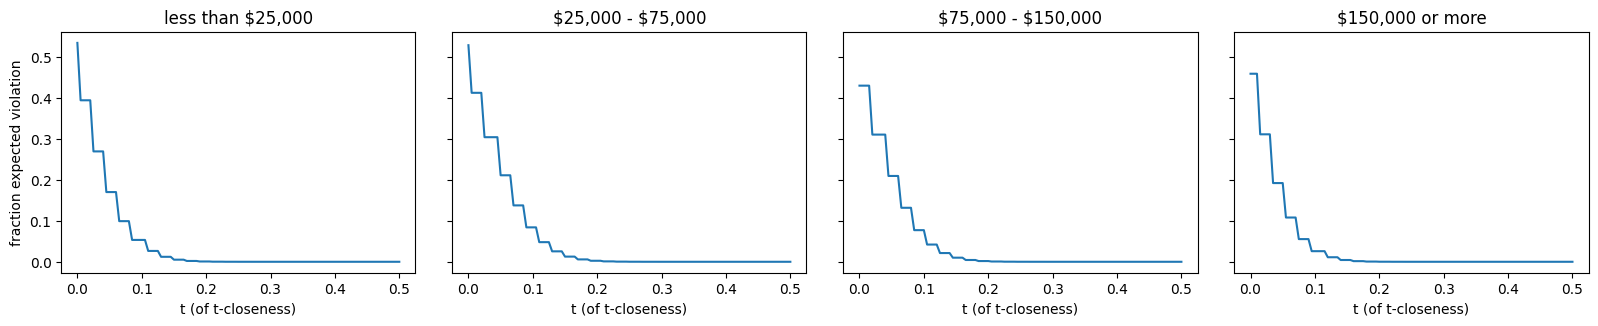

In [109]:
# calculate estimated violations for each t using binomial CDF
est_t_violations_income_df = get_est_t_violations_df(
    income_fractions_df.set_index('income group')['fraction'].items(),
    n,
)
fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
plt.tight_layout()
for i, cat in enumerate(est_t_violations_income_df.columns):
    ax = axes[i]
    ax.plot(est_t_violations_income_df[cat])
    ax.set_title(cat)
    ax.set_xlabel('t (of t-closeness)')
    
_ = axes[0].set_ylabel('fraction expected violation')

In [42]:
all_panels_cohort_df.head(3)

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8

In [81]:
start_time = datetime.now()
print('%s - computing t-closeness for all panels' % start_time)
all_panels_t_closeness_income_df = panels_t_closeness(
    all_panels_cohort_df, demo_col='collapsed_income_code', 
)
end_time = datetime.now()
time = end_time - start_time
print('%s - time: %s' % (end_time, time))
all_panels_t_closeness_income_df.head()

2022-04-28 12:05:17.046775 - computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 12:28:47.936954 - time: 0:23:30.890179


collapsed_income_code  fraction_violate    t  panel_id
0                     1          0.478903  0.0         1
1                     2          0.495781  0.0         1
2                     3          0.504219  0.0         1
3                     4          0.478903  0.0         1
0                   any          1.000000  0.0         1

In [86]:
# align and merge simulated and empirical data

demo_col = 'collapsed_income_code'

agg_t_closeness_income_df = aggregate_t_closeness_violations(
    all_panels_t_closeness_income_df,
    demo_col=demo_col, values_map=collapsed_income_values
)
agg_t_closeness_income_df['income'] = agg_t_closeness_income_df[demo_col].map(collapsed_income_values)

simulated_violations_df = (est_t_violations_income_df
 .reset_index()
 .melt(id_vars=['t'], 
       var_name='income', 
       value_name='fraction_violate')
 .assign(kind='Simulated')
)

plot_df = pd.concat([simulated_violations_df,
                    (agg_t_closeness_income_df
                     .assign(kind='Empirical')
                     .drop(demo_col, axis=1))])
print(plot_df.kind.unique())
plot_df.head()

['Simulated' 'Empirical']


t             income  fraction_violate       kind  upper  lower
0  0.000  less than $25,000          0.533688  Simulated    NaN    NaN
1  0.005  less than $25,000          0.393746  Simulated    NaN    NaN
2  0.010  less than $25,000          0.393746  Simulated    NaN    NaN
3  0.015  less than $25,000          0.393746  Simulated    NaN    NaN
4  0.020  less than $25,000          0.393746  Simulated    NaN    NaN

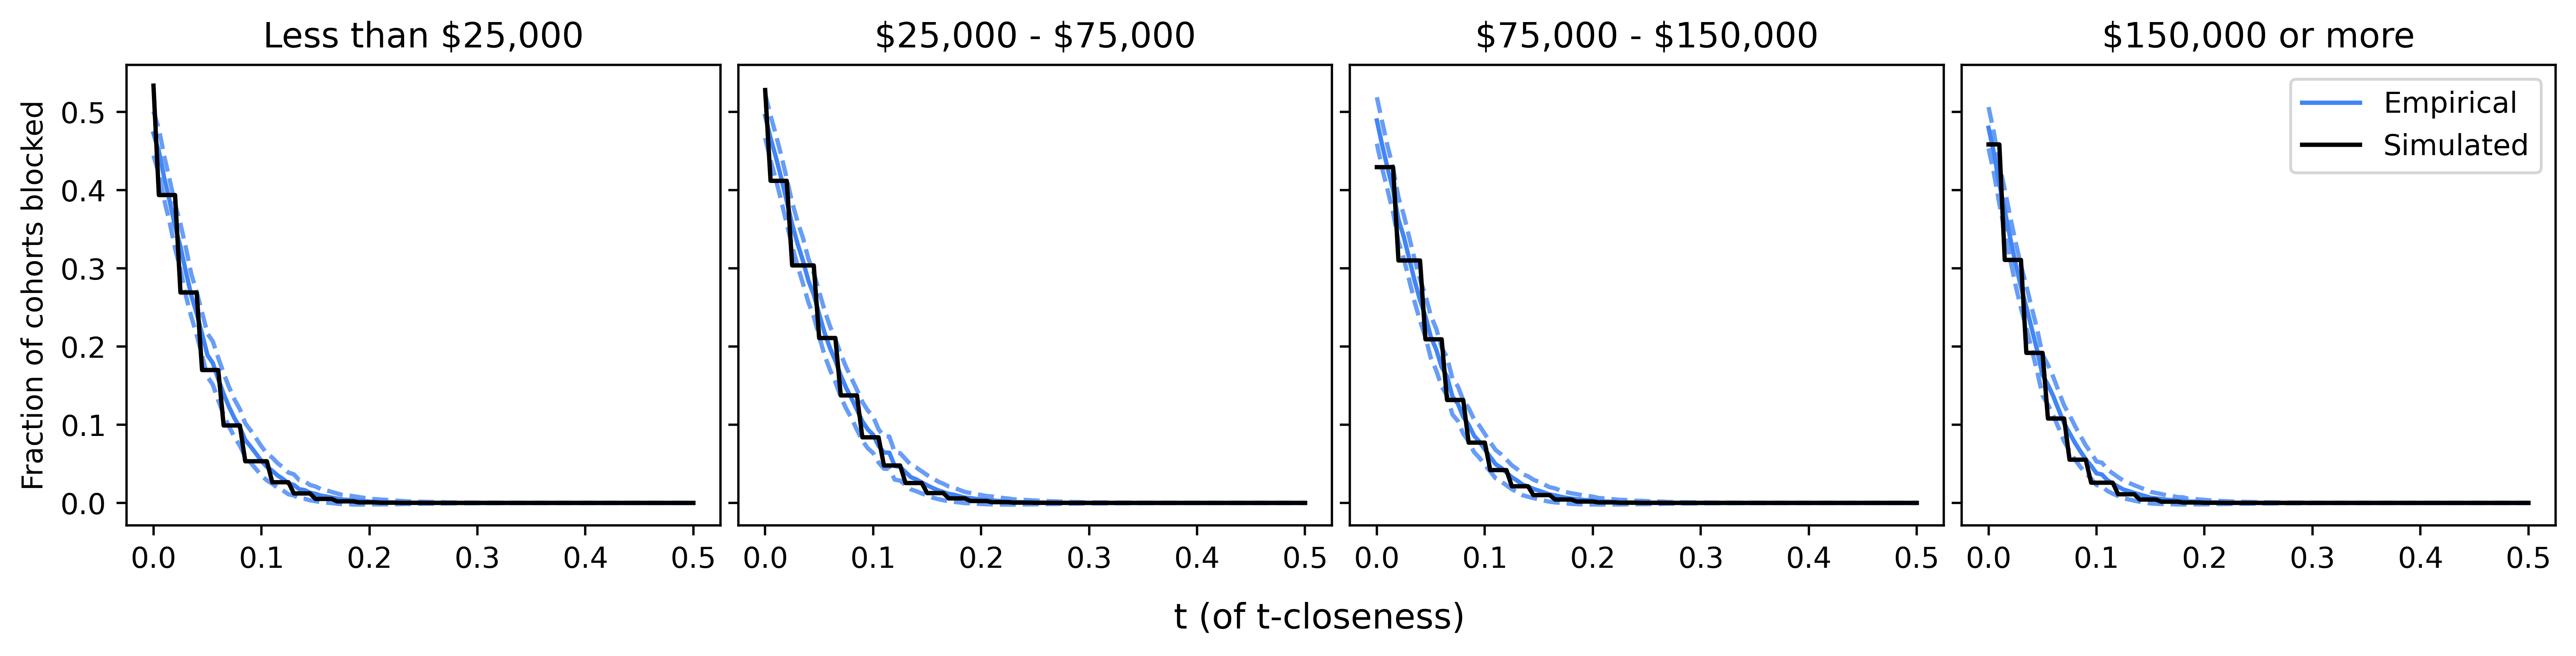

In [100]:
fig, axes = plt.subplots(1, 4, figsize=(4*3.1, 2.8), dpi=500, sharey=True, sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)
for i, cat in enumerate(collapsed_income_values.values()):
    ax = axes[i]
    emp_df = plot_df[(plot_df.income==cat) & (plot_df.kind == 'Empirical')].set_index('t')
    ax.plot(emp_df.lower, '--', alpha=0.8, color=BLUE)
    ax.plot(emp_df.upper, '--', alpha=0.8, color=BLUE)
    ax.plot(emp_df.fraction_violate, color=BLUE, label='Empirical')
    sim_df = plot_df[(plot_df.income==cat) & (plot_df.kind == 'Simulated')].set_index('t')
    ax.plot(sim_df.fraction_violate, color='black', label='Simulated')
    ax.set_title(cat.capitalize())
    
fig.text(0.5, -0.04, 't (of t-closeness)', fontsize='large', ha='center', color='black')
_ = axes[0].set_ylabel('Fraction of cohorts blocked')
_ = ax.legend()

---

## Robustness tests

We repeat the analyses above for cohorts defined and precomputed with other minimum levels of k, using the same panels data.

In [91]:
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

In [112]:
# k=30 was used for the cohorts used in the primary analysis
k=30
robustness_check_k_values = [25, 35, 2000]

In [115]:
def get_cohort_col(k):
    return 'cohort_k%s'%k

def get_avg_cohort_size_col(k):
    return 'avg_cohort_size_k%s'%k

def get_panels_avg_cohort_n(panel_sizes, k):
    """Returns approximation of n for use in the binominial CDF."""
    return round(np.mean(panel_sizes[get_avg_cohort_size_col(k)]))

In [116]:
for check_k in robustness_check_k_values:
    panel_sizes[
        get_avg_cohort_size_col(k)
    ] = (all_panels_cohort_df
         .groupby(['panel_id', get_cohort_col(check_k)])
         .size()
         .rename('size')
         .reset_index()
         .groupby(['panel_id'])
         .agg({'size': [np.mean]}))
    
panel_sizes.head()

panel_size  avg_cohort_size  \
panel_id                                
1              23250        49.050633   
2              23209        47.172764   
3              23831        50.170526   
4              22897        50.323077   
5              23761        48.690574   

          avg_randomly_shuffled_simhash_cohort_size  avg_cohort_size_k25  \
panel_id                                                                   
1                                         48.136646            39.075630   
2                                         49.171610            39.878007   
3                                         49.034979            40.255068   
4                                         48.002096            40.741993   
5                                         48.294715            39.800670   

          avg_cohort_size_k35  avg_cohort_size_k2000  avg_cohort_size_k30  
panel_id                                                                   
1                   58.270677               2906.250             2906.250  
2                   58.167920               2901.125             2901.125  
3                   58.124390               2978.875             2978.875  
4                   58.710256               2862.125             2862.125  
5                   57.393720               2970.125             2970.125

In [121]:
# compute simulated t-closeness violations for both race and income
# for the various k values
# store in a dictionary mapping k to the df
est_t_closeness_violation_race_dfs = {k: est_t_violations_df}
est_t_closeness_violation_income_dfs = {k: est_t_violations_income_df}

for check_k in robustness_check_k_values:
    check_k_n = get_panels_avg_cohort_n(panel_sizes, check_k)
    print('for k=%s; n=%s' % (check_k, check_k_n))
    est_t_closeness_violation_race_dfs[check_k] = get_est_t_violations_df(
        race_fractions_df.set_index('race')['fraction'].items(),
        check_k_n,
    )
    est_t_closeness_violation_income_dfs[check_k] = get_est_t_violations_df(
        income_fractions_df.set_index('income group')['fraction'].items(),
        check_k_n,
    )

for k=25; n=40
for k=35; n=58
for k=2000; n=2858


Simulated expected t-closeness violations
k=25


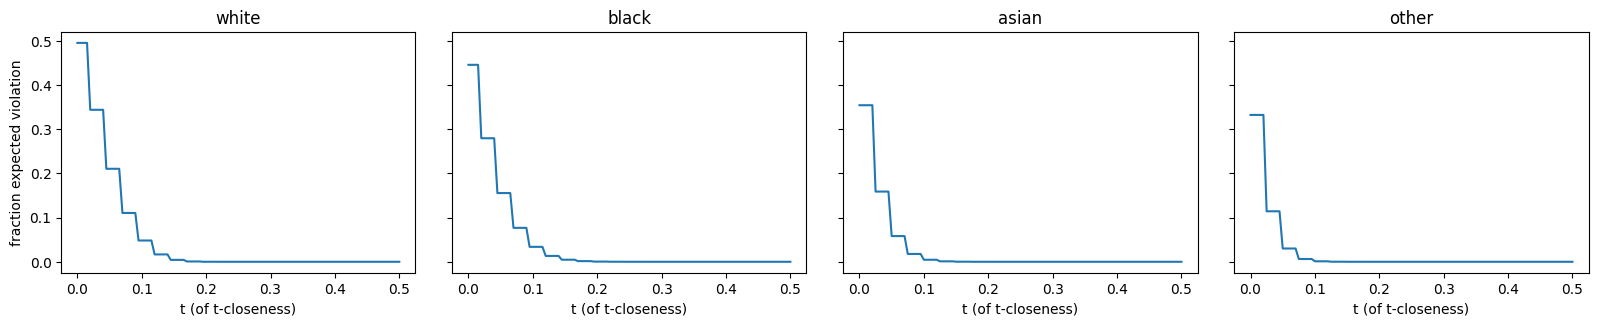

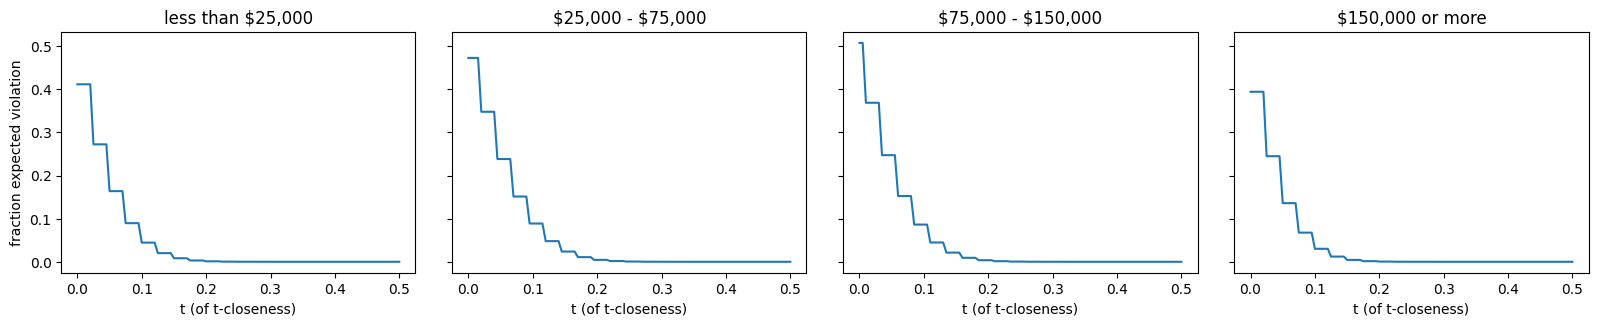

k=30


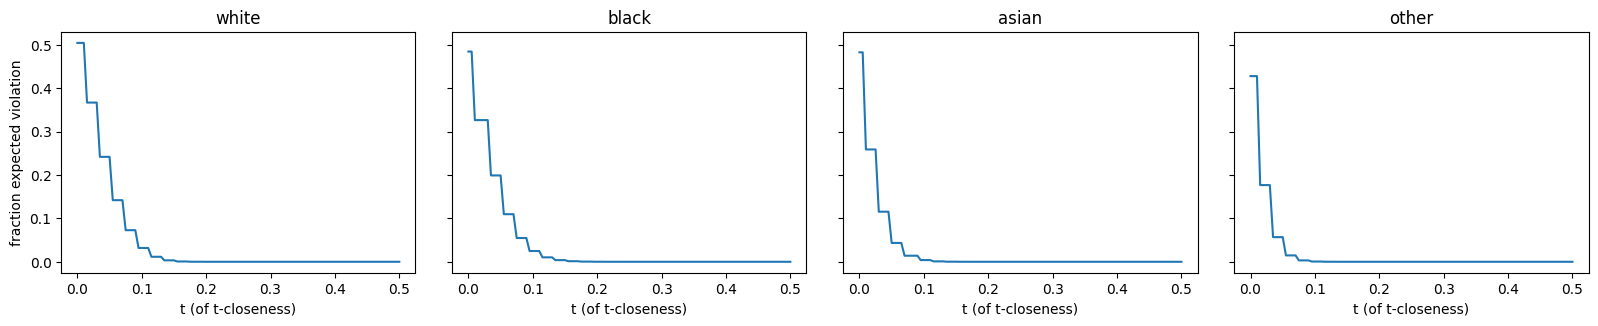

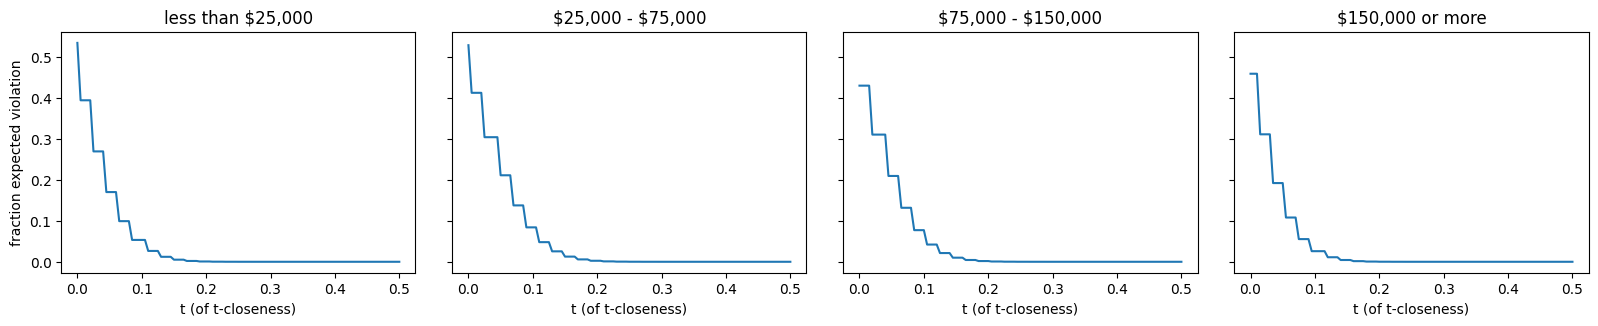

k=35


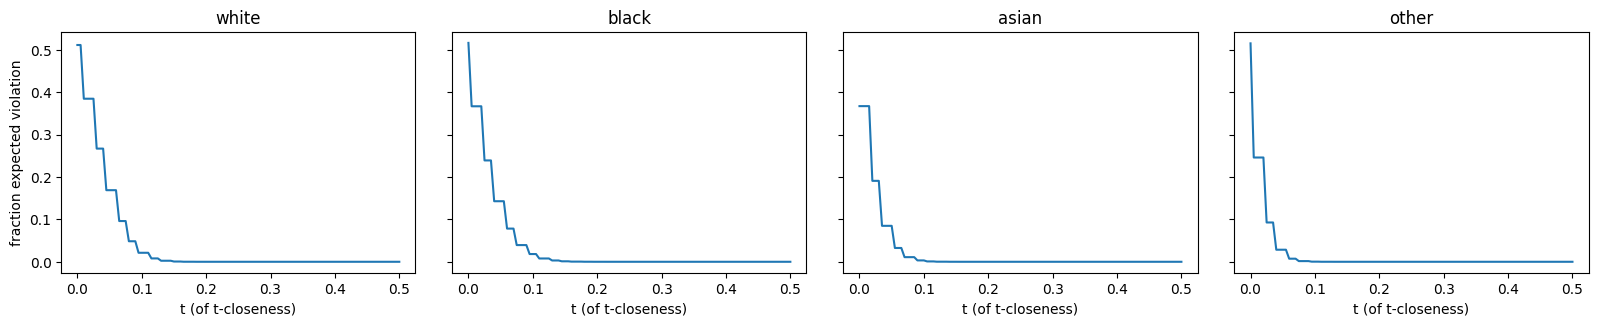

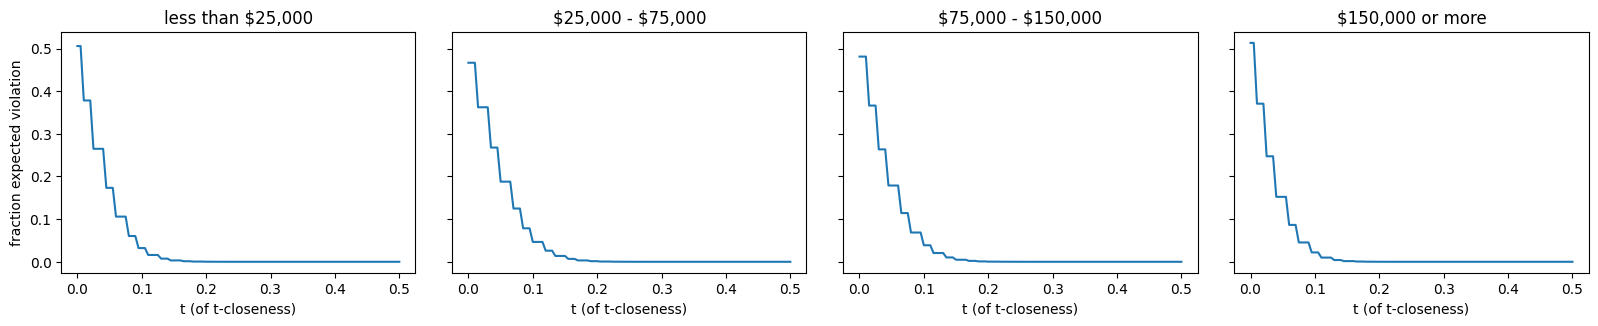

k=2000


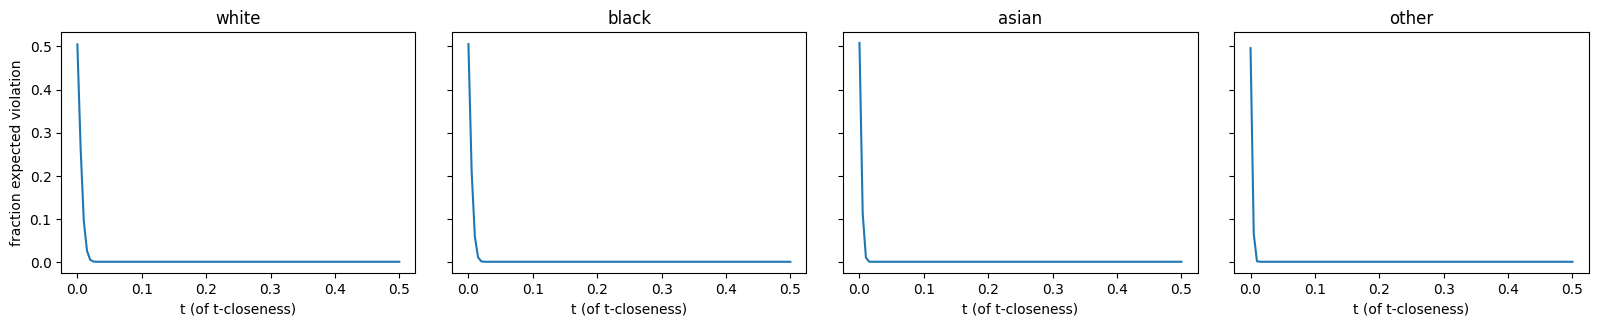

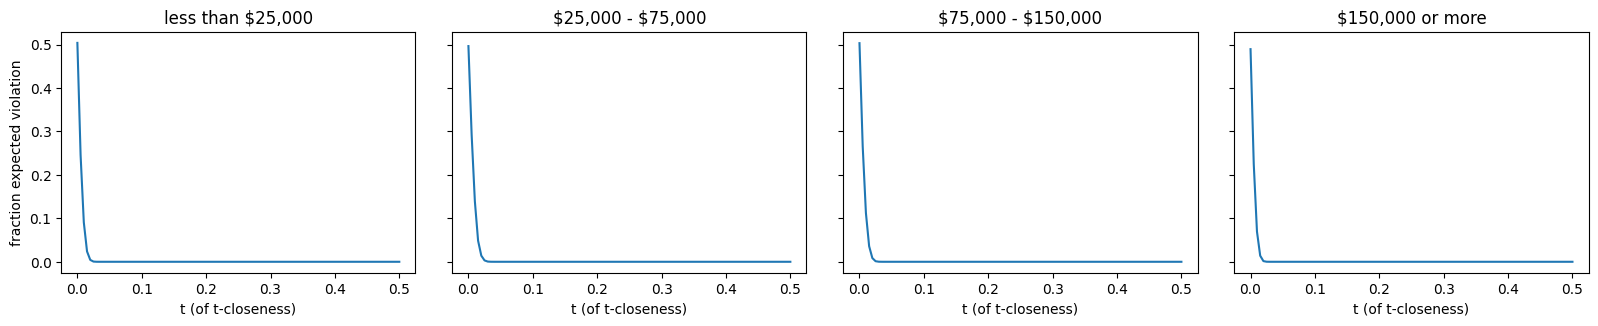

In [133]:
# plot estimations by themselves
print('Simulated expected t-closeness violations')
for check_k in sorted([k]+robustness_check_k_values):
    print('k=%s'%check_k)
    sim_dfs = [
        est_t_closeness_violation_race_dfs[check_k],
        est_t_closeness_violation_income_dfs[check_k]
    ]
    for sim_df in sim_dfs:
        fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
        plt.tight_layout()
        for i, cat in enumerate(sim_df.columns):
            ax = axes[i]
            ax.plot(sim_df[cat])
            ax.set_title(cat)
            ax.set_xlabel('t (of t-closeness)')
        _ = axes[0].set_ylabel('fraction expected violation')
        plt.show()

In [198]:
# compute aggregated t-closeness for both race and income
# for the various k values
# store in a dictionary mapping k to the df
# initialize dicts with already computed dfs for k
agg_t_closeness_race_dfs = {k: agg_t_closeness_df}
agg_t_closeness_income_dfs = {k: agg_t_closeness_income_df}

for check_k in robustness_check_k_values:
    print('for k=%s' % (check_k))
    t1 = datetime.now()
    print('%s - race: computing t-closeness for all panels' % t1)
    demo_col = 'racial_background'
    agg_t_closeness_race_dfs[check_k] = aggregate_t_closeness_violations(
        panels_t_closeness(
            all_panels_cohort_df, demo_col=demo_col,
            cohort_name=get_cohort_col(check_k),
        ), 
        demo_col=demo_col, values_map=race_values
    ).assign(race=lambda x: x[demo_col].map(race_values))
    t2 = datetime.now()
    print('%s - time: %s' % (t2, t2 - t1))
    print('%s - income: computing t-closeness for all panels' % t2)
    demo_col = 'collapsed_income_code'
    agg_t_closeness_income_dfs[check_k] = aggregate_t_closeness_violations(
        panels_t_closeness(
            all_panels_cohort_df, demo_col=demo_col,
            cohort_name=get_cohort_col(check_k),
        ), 
        demo_col=demo_col, values_map=collapsed_income_values
    ).assign(income=lambda x: x[demo_col].map(collapsed_income_values))
    t3 = datetime.now()
    print('%s - time: %s' % (t3, t3 - t2))
    

for k=25
2022-04-28 18:09:19.551597 - race: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 18:34:12.985846 - time: 0:24:53.434249
2022-04-28 18:34:12.985846 - income: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 18:57:21.656631 - time: 0:23:08.670785
for k=35
2022-04-28 18:57:21.656865 - race: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 19:21:17.167009 - time: 0:23:55.510144
2022-04-28 19:21:17.167009 - income: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 19:48:38.823813 - time: 0:27:21.656804
for k=2000
2022-04-28 19:48:38.825338 - race: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 20:11:04.573305 - time: 0:22:25.747967
2022-04-28 20:11:04.573305 - income: computing t-closeness for all panels
computing t-closeness for 520 panels
2022-04-28 20:30:24.918874 - time: 0:19:20.345569


In [199]:
agg_t_closeness_income_dfs[25].head()

t collapsed_income_code  fraction_violate     upper     lower  \
0  0.0                     1          0.467943  0.493203  0.442682   
1  0.0                     2          0.494711  0.521068  0.468355   
2  0.0                     3          0.491293  0.518345  0.464240   
3  0.0                     4          0.476967  0.500244  0.453690   
4  0.0                   any          1.000000  1.000000  1.000000   

                income  
0    less than $25,000  
1   \$25,000 - $75,000  
2  \$75,000 - $150,000  
3    \$150,000 or more  
4                  any

In [200]:
agg_t_closeness_race_dfs[25].head()

t racial_background  fraction_violate     upper     lower   race
0  0.0               1.0          0.515170  0.540214  0.490126  white
1  0.0               2.0          0.481066  0.506733  0.455399  black
2  0.0               3.0          0.453843  0.480485  0.427201  asian
3  0.0               5.0          0.454056  0.480248  0.427863  other
4  0.0               any          1.000000  1.000000  1.000000    any

Set up the dataframes that contain both the empirical and expected t-closeness values.

In [201]:
race_t_closeness_violations_emp_exp_dfs = dict() # k:df
income_t_closeness_violations_emp_exp_dfs = dict() # k:df
    
iterables = [
    ('racial_background', 'race', 
     est_t_closeness_violation_race_dfs, agg_t_closeness_race_dfs,
     race_t_closeness_violations_emp_exp_dfs),
    ('collapsed_income_code', 'income', 
     est_t_closeness_violation_income_dfs, agg_t_closeness_income_dfs,
     income_t_closeness_violations_emp_exp_dfs)
]
for check_k in sorted([k]+robustness_check_k_values):
    for (demo_col, var_name, exp_dfs, emp_dfs, emp_exp_dfs) in iterables:
        emp_exp_dfs[check_k] = pd.concat([(exp_dfs[check_k]
                    .reset_index()
                    .melt(id_vars=['t'], 
                          var_name=var_name, 
                          value_name='fraction_violate')
                    .assign(kind='Simulated')),
                   (emp_dfs[check_k]
                     .assign(kind='Empirical')
                     .drop(demo_col, axis=1))])

In [202]:
race_t_closeness_violations_emp_exp_dfs[30].head()

t   race  fraction_violate       kind  upper  lower
0  0.000  white          0.504053  Simulated    NaN    NaN
1  0.005  white          0.504053  Simulated    NaN    NaN
2  0.010  white          0.504053  Simulated    NaN    NaN
3  0.015  white          0.366606  Simulated    NaN    NaN
4  0.020  white          0.366606  Simulated    NaN    NaN

k=25


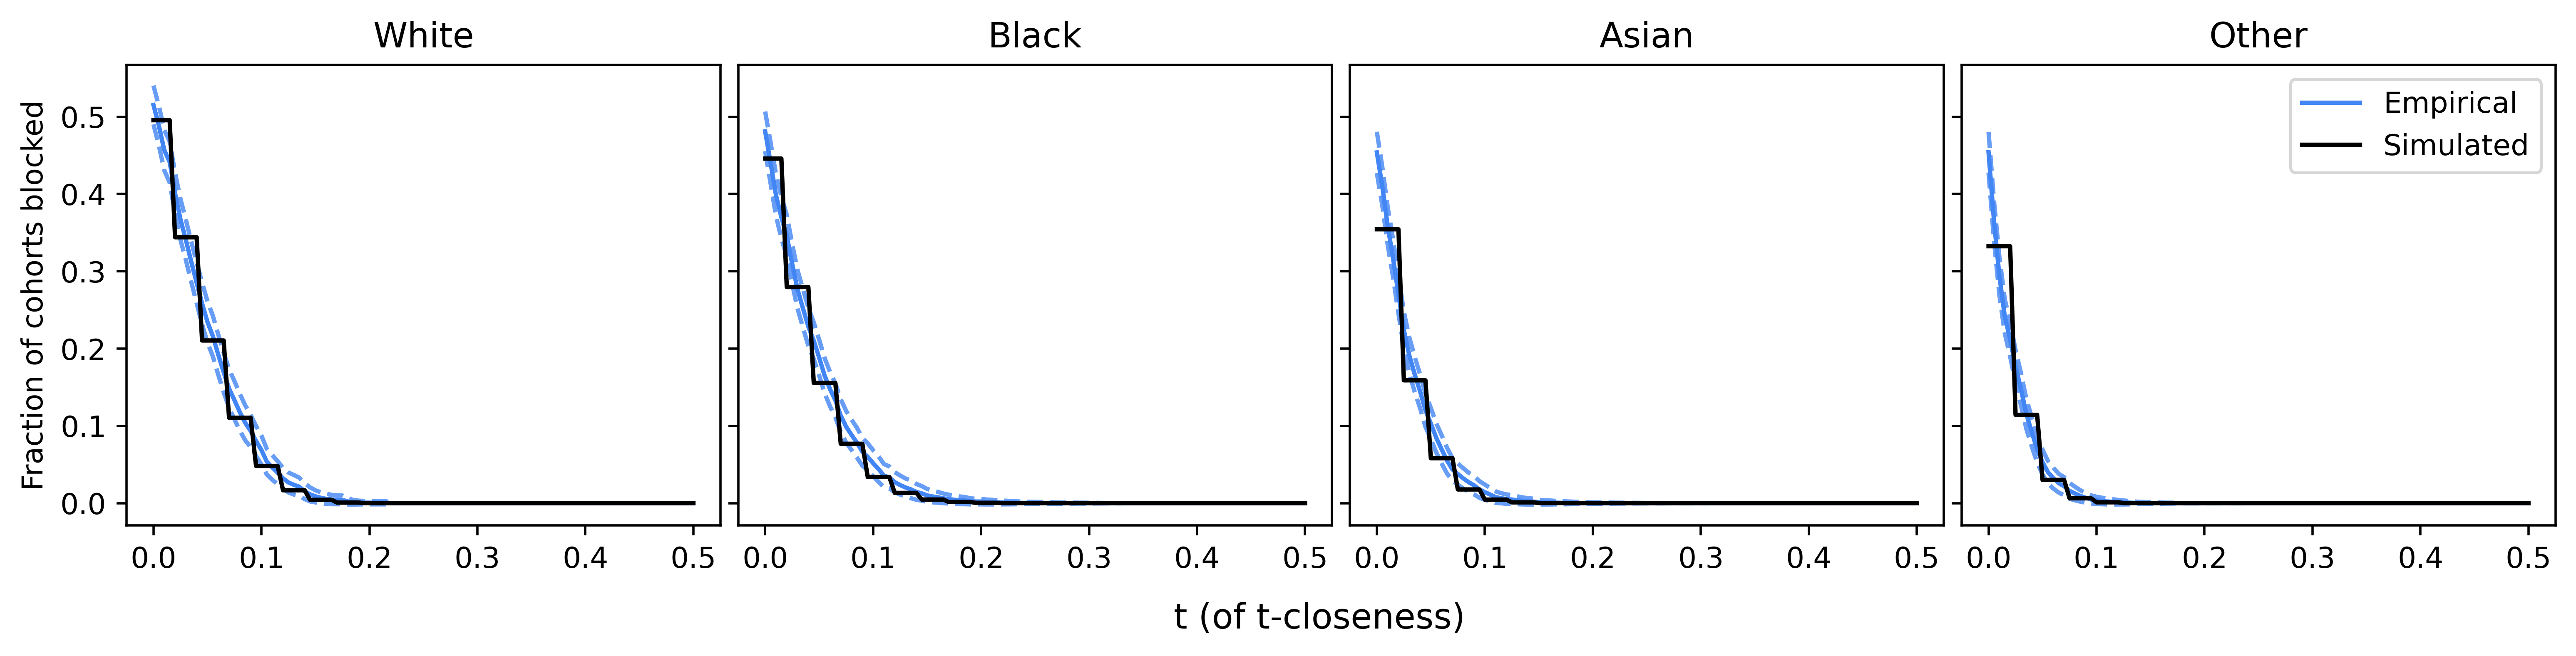

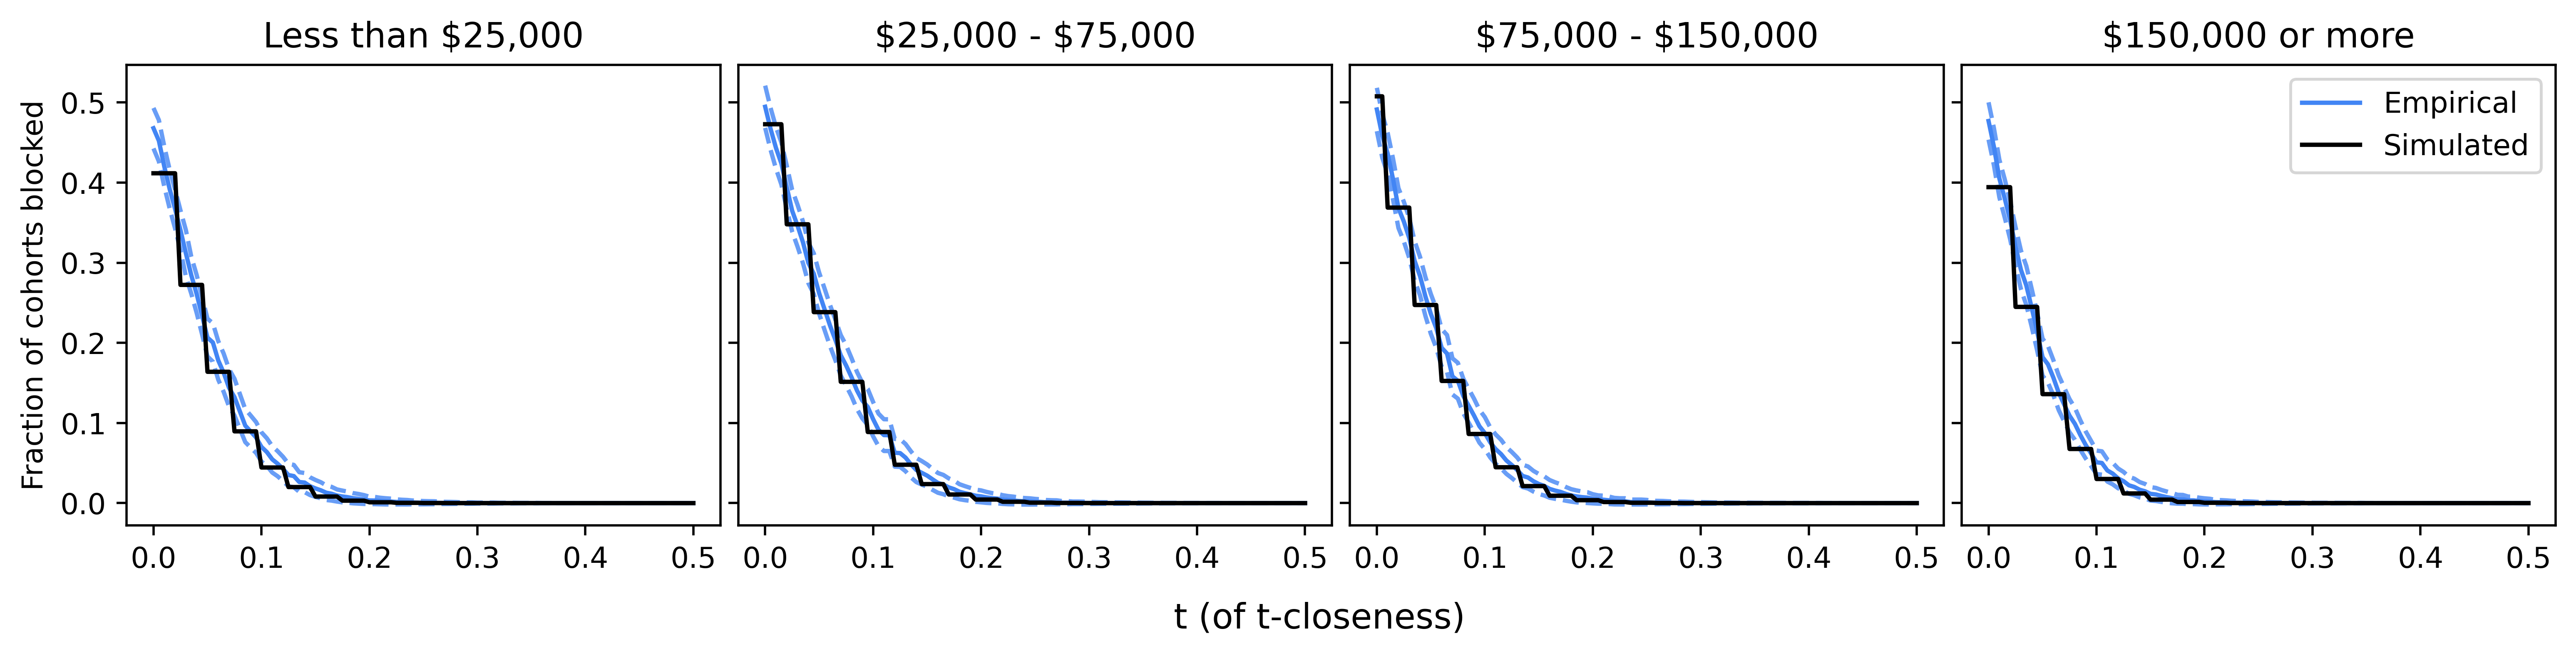

k=30


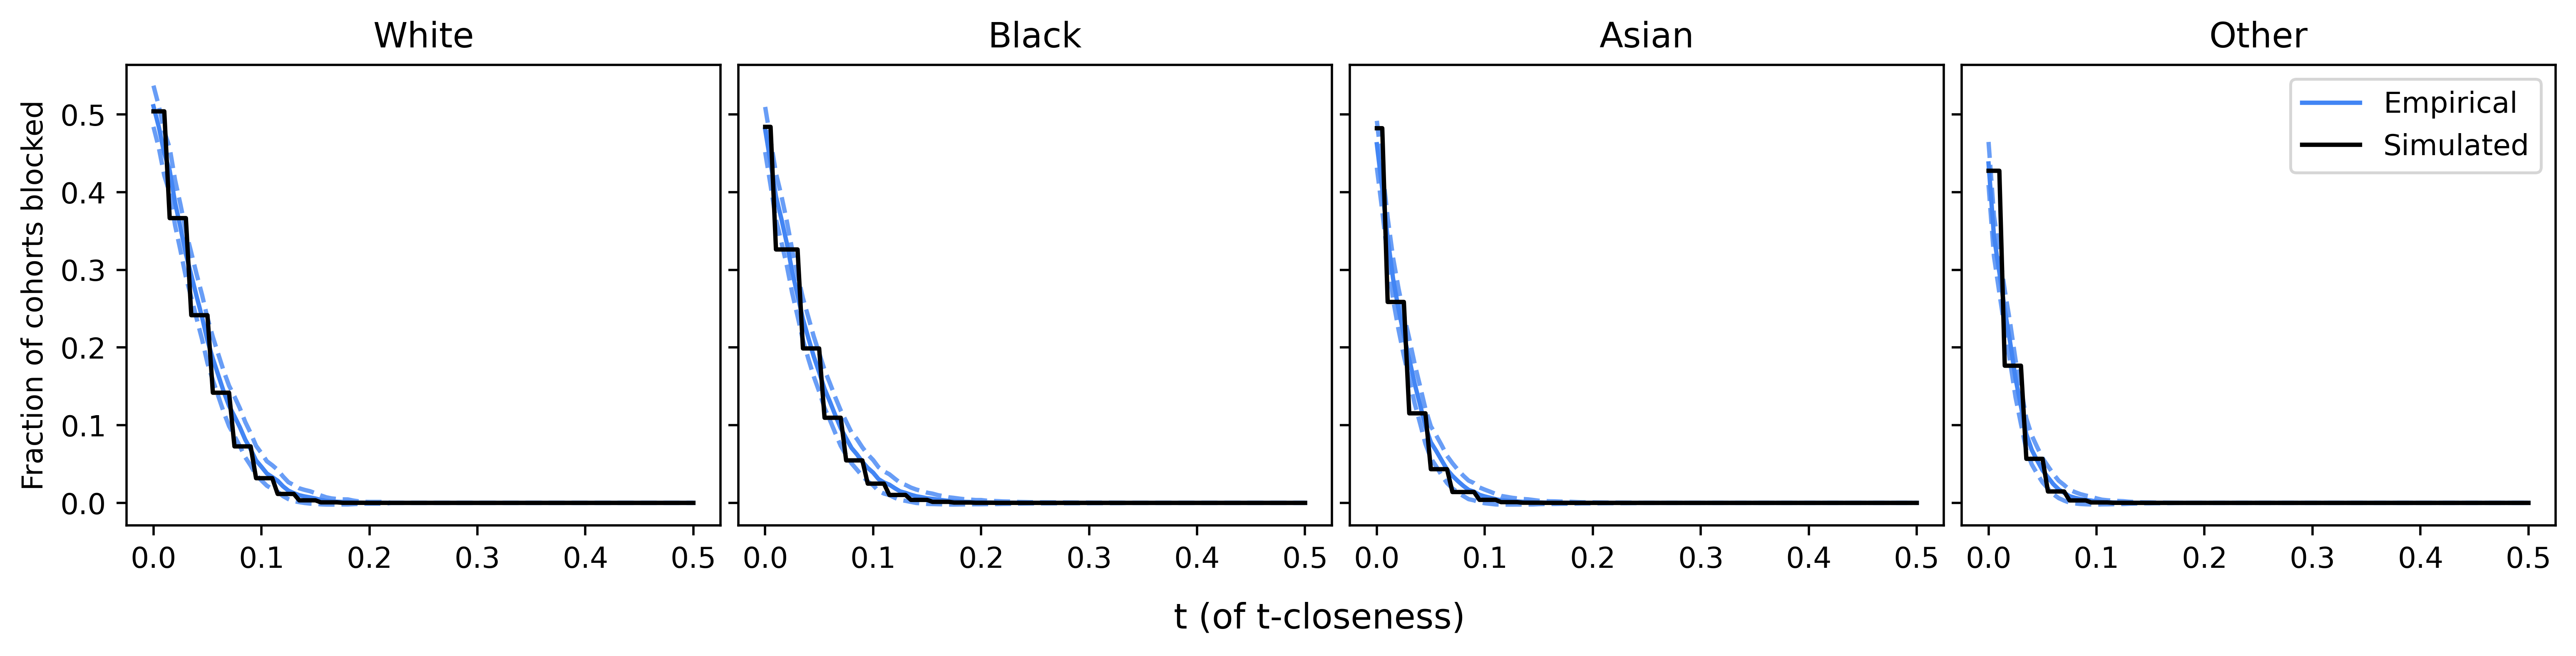

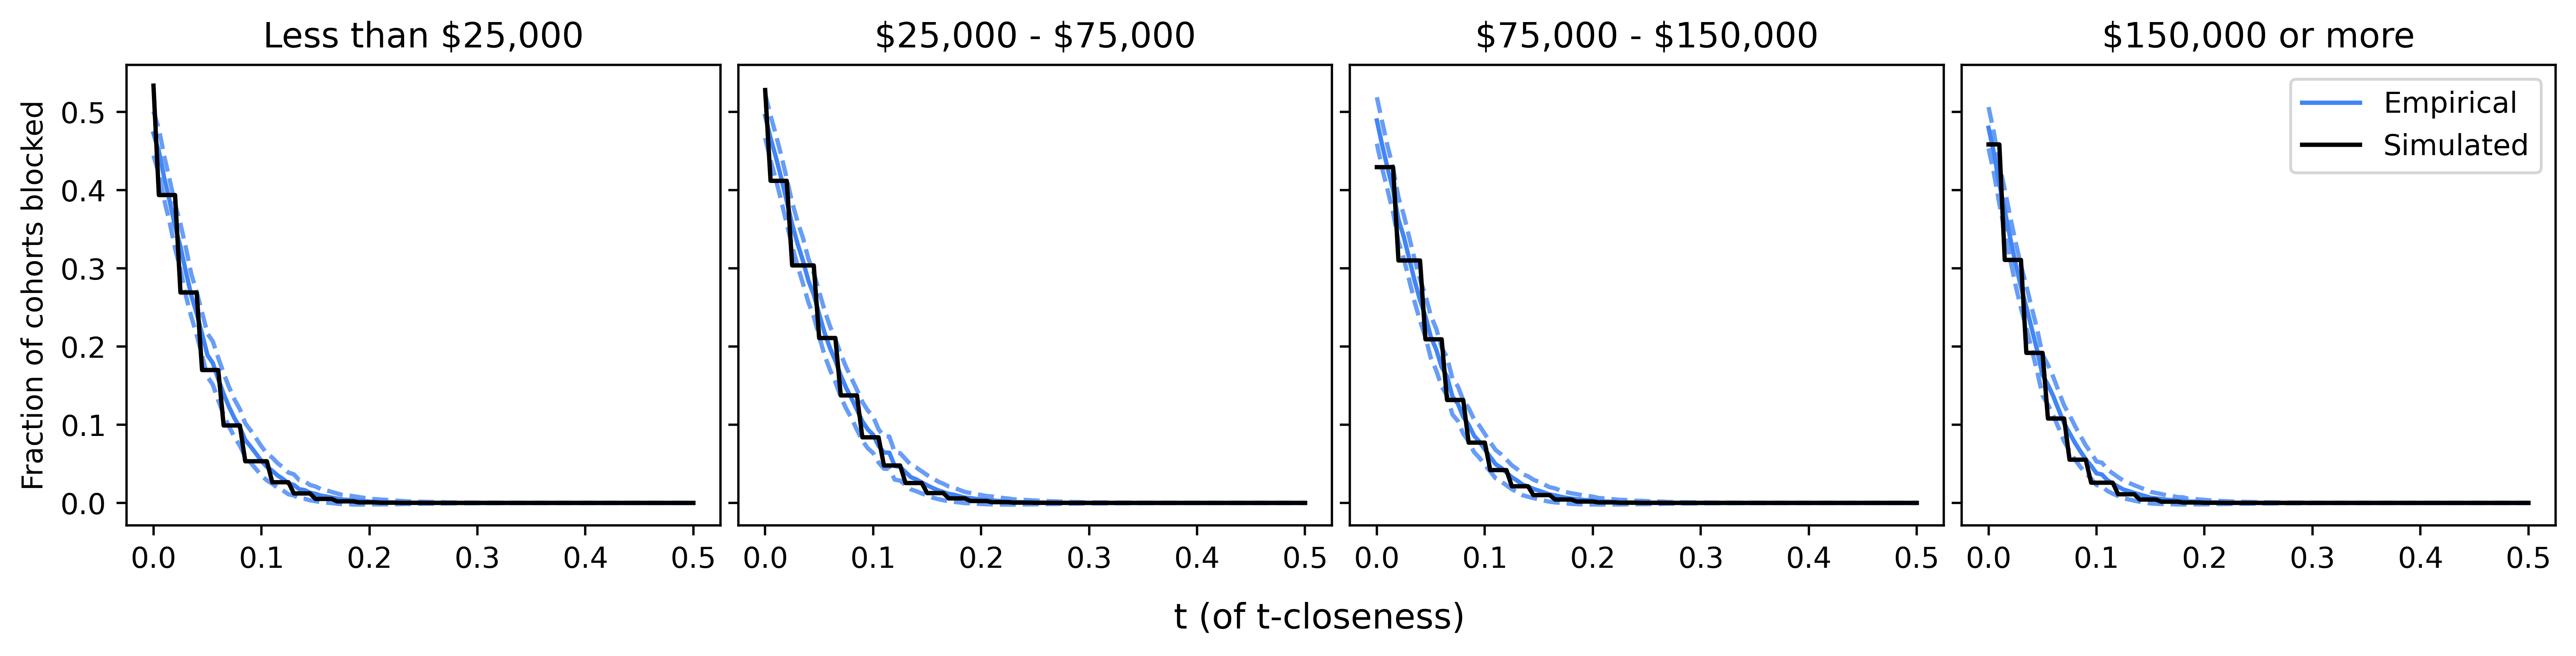

k=35


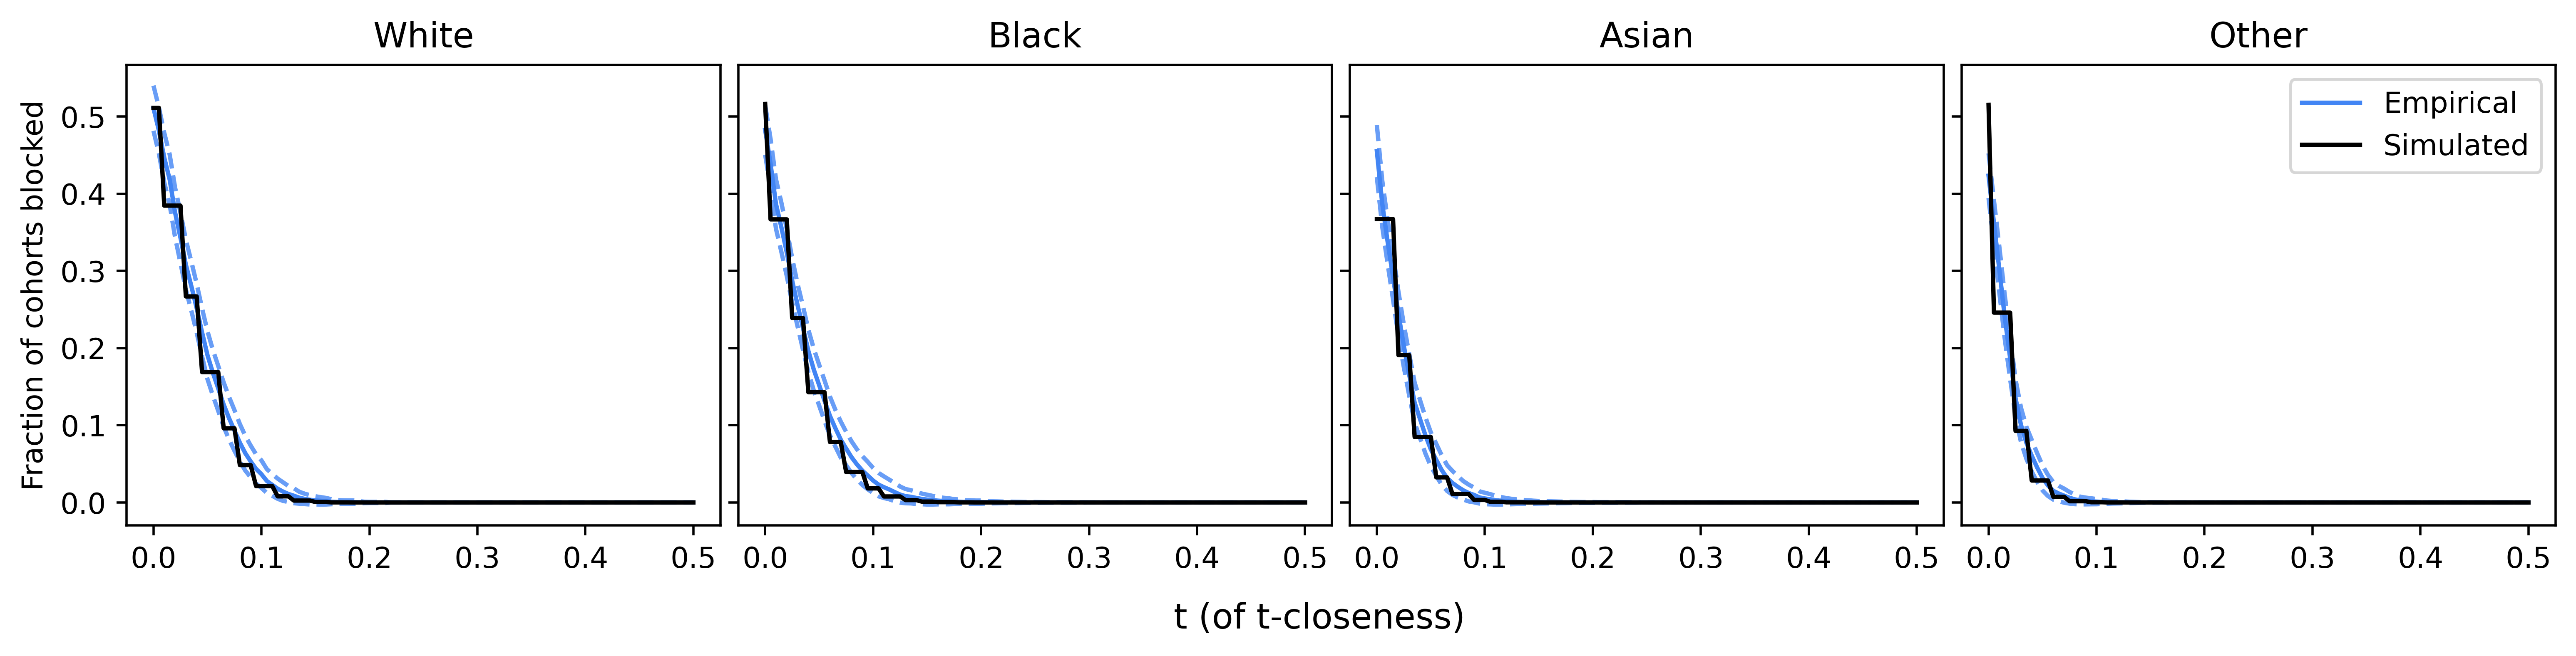

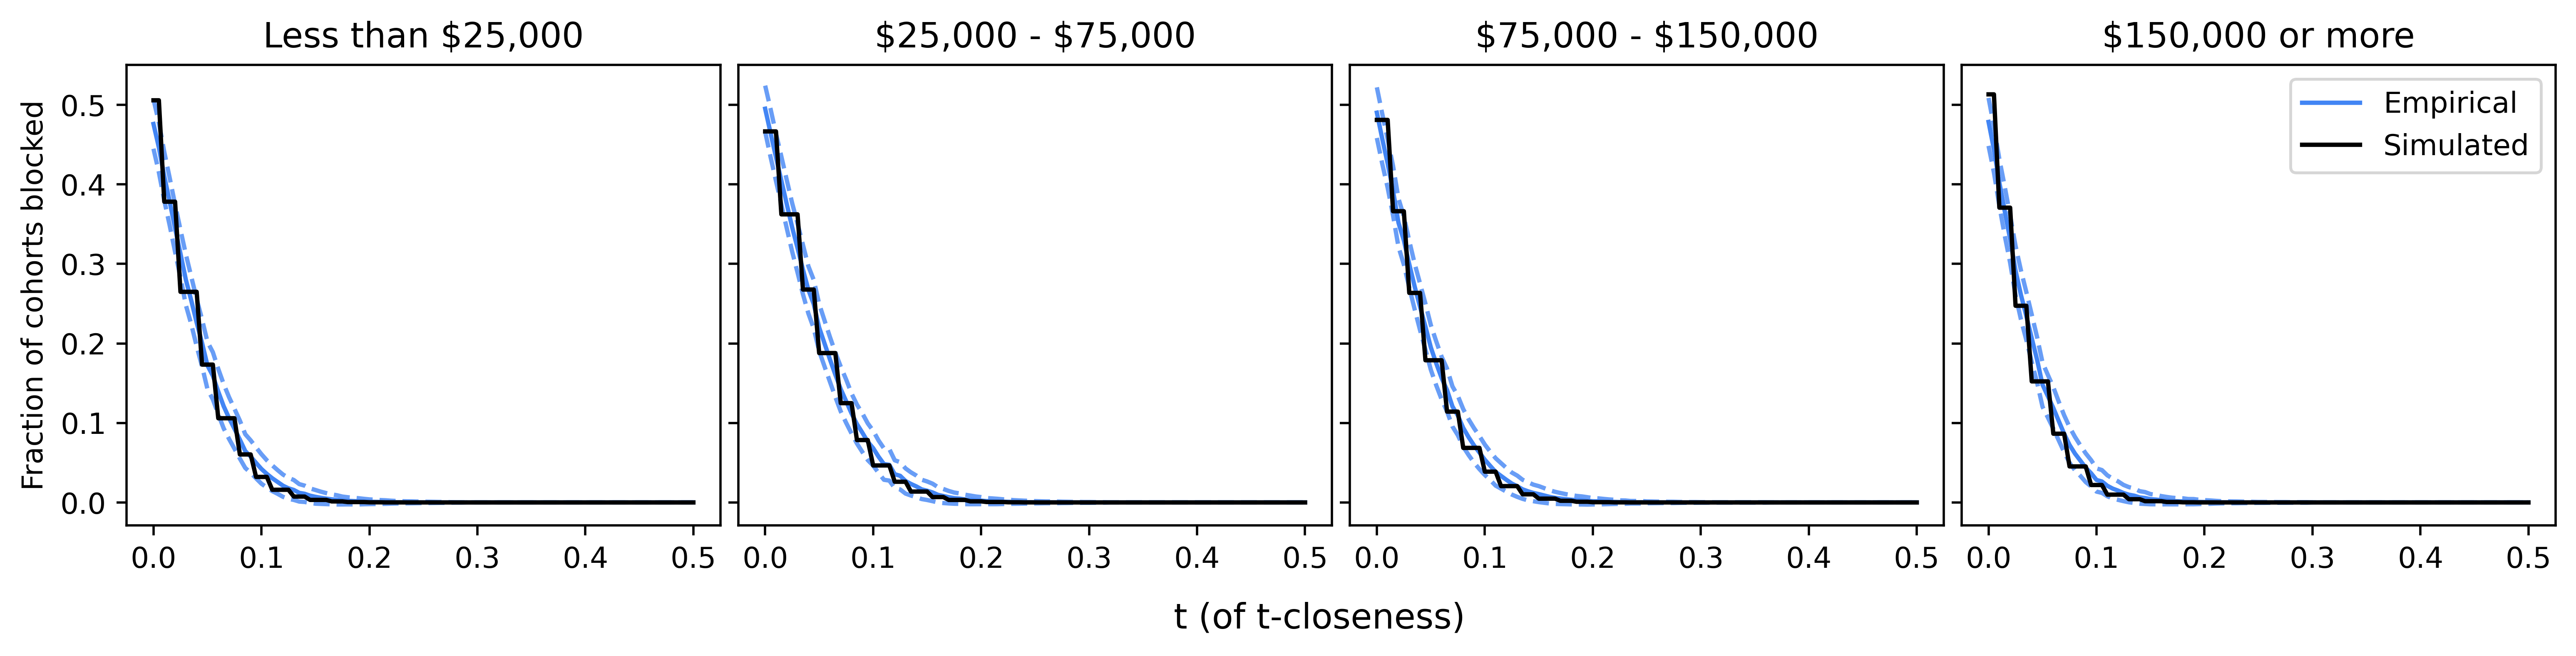

k=2000


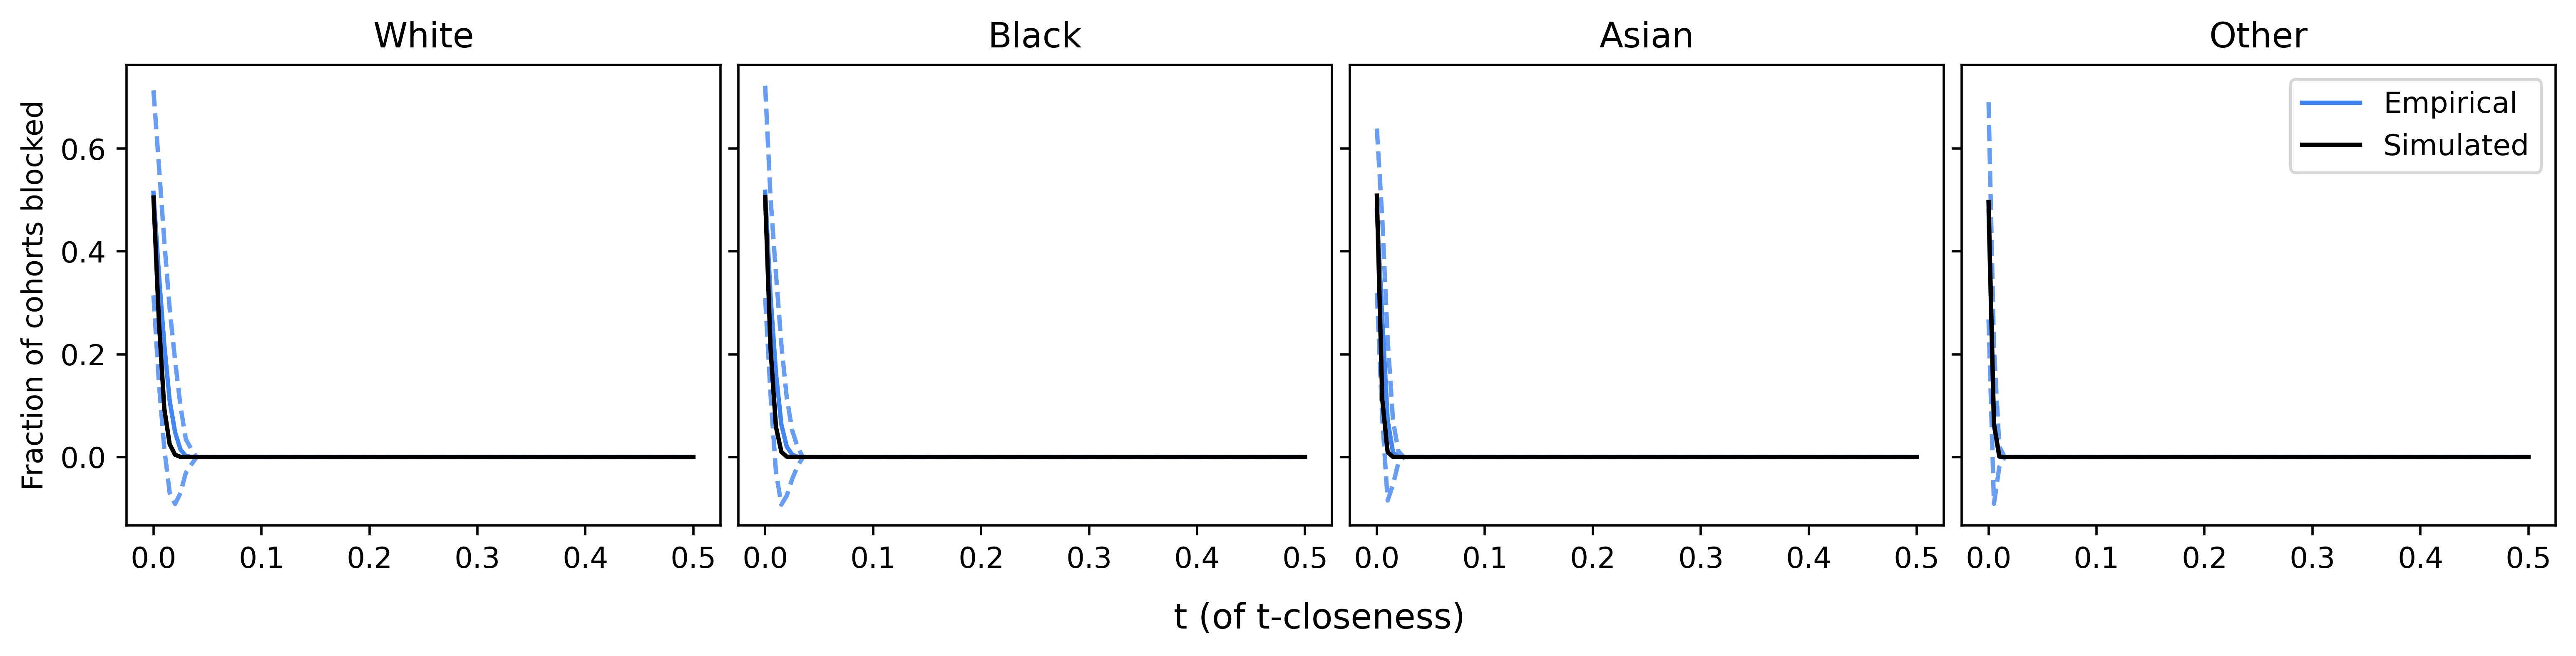

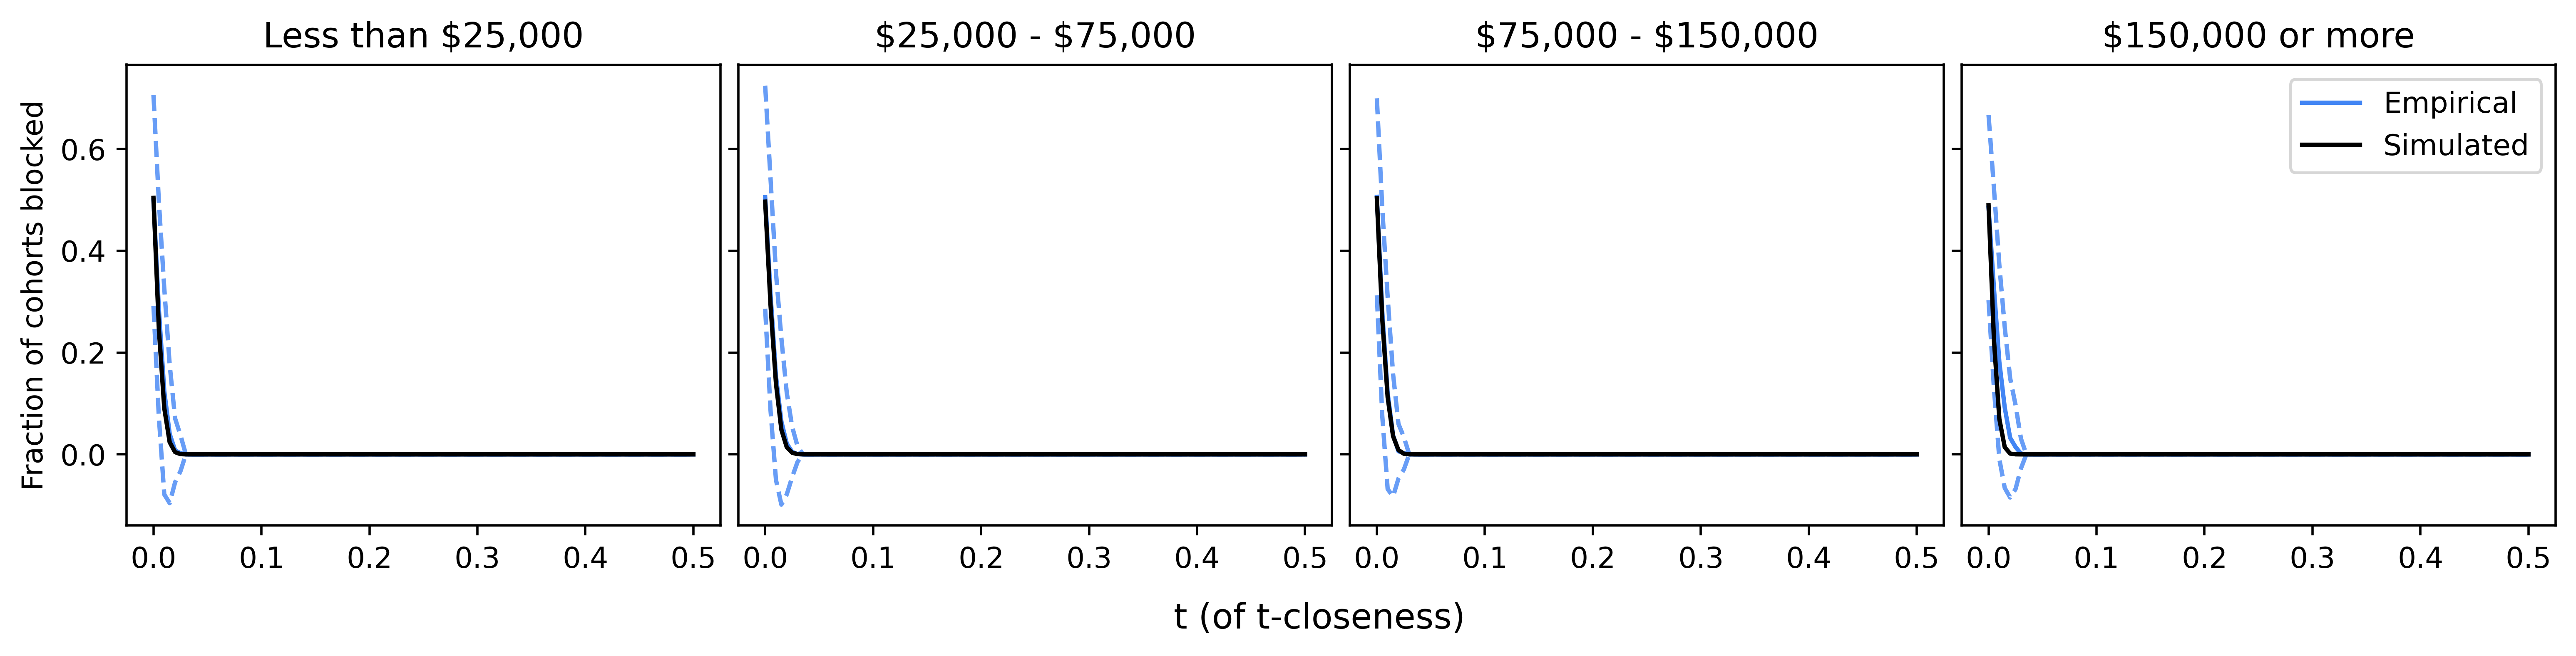

In [203]:
for check_k in sorted([k]+robustness_check_k_values):
    print('k=%s'%check_k)
    for (var_name, emp_exp_dfs) in [
        ('race', race_t_closeness_violations_emp_exp_dfs), 
        ('income', income_t_closeness_violations_emp_exp_dfs)
    ]:
        plot_df = emp_exp_dfs[check_k]
        fig, axes = plt.subplots(1, 4, figsize=(4*3.1, 2.8), dpi=500, sharey=True, sharex=True)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.03)
        categories = [c for c in plot_df[plot_df.columns[1]].unique() if c not in [np.nan,'any']]
        for i, cat in enumerate(categories):
            ax = axes[i]
            emp_df = plot_df[(plot_df[var_name]==cat) & (plot_df.kind == 'Empirical')].set_index('t')
            ax.plot(emp_df.lower, '--', alpha=0.8, color=BLUE)
            ax.plot(emp_df.upper, '--', alpha=0.8, color=BLUE)
            ax.plot(emp_df.fraction_violate, color=BLUE, label='Empirical')
            sim_df = plot_df[(plot_df[var_name]==cat) & (plot_df.kind == 'Simulated')].set_index('t')
            ax.plot(sim_df.fraction_violate, color='black', label='Simulated')
            ax.set_title(cat.capitalize())
        fig.text(0.5, -0.04, 't (of t-closeness)', fontsize='large', ha='center', color='black')
        _ = axes[0].set_ylabel('Fraction of cohorts blocked')
        _ = ax.legend()
        plt.show()

--- 

# Appendix

## Binomial models mimic random cohort data

Here, we check that the binomial CDF representation matches if we simulated cohorts by shuffling simhashes:

### Read in the panel random cohorts comparison data.

In [29]:
all_panels_randomly_shuffled_simhash_cohorts_fpath = \
    '../output/comscore_cps_income_race_panels_randomly_shuffled_simhash_cohorts.csv'
all_panels_random_cohort_df = pd.read_csv(all_panels_randomly_shuffled_simhash_cohorts_fpath)
all_panels_random_cohort_df.head()

machine_id  week  panel_id  collapsed_income_code  racial_background  \
0   216306561     1         1                      1                1.0   
1   218977211     1         1                      1                1.0   
2   227099882     1         1                      1                1.0   
3   205507144     1         1                      1                1.0   
4   205274490     1         1                      1                1.0   

  stratify       simhash  cohort  cohort_k25  cohort_k30  cohort_k35  \
0  1.0,1.0  6.874264e+14     256         313         256         220   
1  1.0,1.0  6.822101e+14     253         310         253         217   
2  1.0,1.0  1.873246e+14      73          90          73          61   
3  1.0,1.0  7.253560e+14     277         339         277         235   
4  1.0,1.0  1.039863e+15     445         545         445         378   

   cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0         151           83             7             5  
1         150           82             7             5  
2          44           23             2             2  
3         163           89             8             6  
4         258          140            14             8

When we do this analysis we make some assumptions that we check here.

1. The true and comparison panel cohorts data are indeed good comparisons: We check this by comparing the average cohort sizes per panel.

2. The expected fraction of cohorts that violate t-closeness for a given category (for each panel) can be approximated by a binomial distribution based on cohort sizes, t, and the fraction of the population in the category: We calculate the expected value estimates for each panel and compare to the randomly shuffled simhash comparison data.

### Panel size comparison

In [30]:
def compare_panel_cohort_sizes(true_df, other_df, 
                               other_avg_cohort_size_name):
    """
    Returns a dataframe with columns
    panel_id, panel_size, avg_cohort_size, other_avg_cohort_size_name
    
    where:
        - the input dfs have same panel ids but different 
        cohort assignments
        - avg_cohort_size, other_avg_cohort_size_name represent 
        mean cohort size for given panel_id
    """
    panel_sizes = true_df.groupby(
        'panel_id'
    ).size().rename('panel_size').to_frame()
    panel_sizes['avg_cohort_size'] = true_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    panel_sizes[other_avg_cohort_size_name] = other_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    return panel_sizes

panel_size  avg_cohort_size  \
panel_id                                
260            18286        49.961749   
468            18286        51.655367   
416            18286        50.794444   

          avg_randomly_shuffled_simhash_cohort_size  
panel_id                                             
260                                       50.374656  
468                                       50.513812  
416                                       52.245714

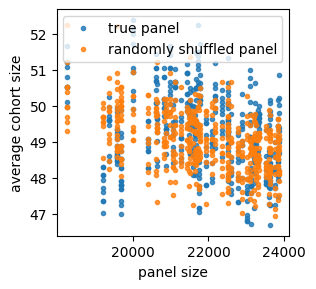

In [31]:
other_avg_cohort_size_name = 'avg_randomly_shuffled_simhash_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df,
    all_panels_random_cohort_df, 
    other_avg_cohort_size_name)

# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly shuffled panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

panel_sizes_sorted.head(3)

Calculate t-closeness for all $t \in T$, for each category, for each panel.

How long should this take?
Test with subset of panel ids.

In [32]:
P_subset = 10

panel_ids = all_panels_random_cohort_df.panel_id.unique()[:P_subset]

start_time = datetime.now()
panels_t_closeness_subset_df = panels_t_closeness(
    all_panels_random_cohort_df, panel_ids=panel_ids
)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s panels' % (time, P_subset))

print('expect to take %s for all panels' % (
    (all_panels_random_cohort_df.panel_id.nunique()/P_subset * time)
))
panels_t_closeness_subset_df.head()

computing t-closeness for 10 panels
took 0:00:28.266918 for 10 panels
expect to take 0:24:29.879736 for all panels


racial_background  fraction_violate    t  panel_id
0               1.0          0.519669  0.0         1
1               2.0          0.478261  0.0         1
2               3.0          0.455487  0.0         1
3               5.0          0.440994  0.0         1
0               any          1.000000  0.0         1

In [34]:
all_panels_random_cohorts_t_closeness_df = panels_t_closeness(
    all_panels_random_cohort_df
)
all_panels_random_cohorts_t_closeness_df.head()

computing t-closeness for 520 panels


racial_background  fraction_violate    t  panel_id
0               1.0          0.519669  0.0         1
1               2.0          0.478261  0.0         1
2               3.0          0.455487  0.0         1
3               5.0          0.440994  0.0         1
0               any          1.000000  0.0         1

In [35]:
agg_t_closeness_random_cohorts_df = aggregate_t_closeness_violations(
    all_panels_random_cohorts_t_closeness_df,
    demo_col='racial_background', values_map=race_values
)
agg_t_closeness_random_cohorts_df['race'] = agg_t_closeness_random_cohorts_df['racial_background'].map(race_values)
agg_t_closeness_random_cohorts_df.head()

t racial_background  fraction_violate     upper     lower   race
0  0.0               1.0          0.511442  0.539414  0.483470  white
1  0.0               2.0          0.482362  0.510032  0.454692  black
2  0.0               3.0          0.464810  0.492372  0.437248  asian
3  0.0               5.0          0.436656  0.465095  0.408218  other
4  0.0               any          1.000000  1.000000  1.000000    any

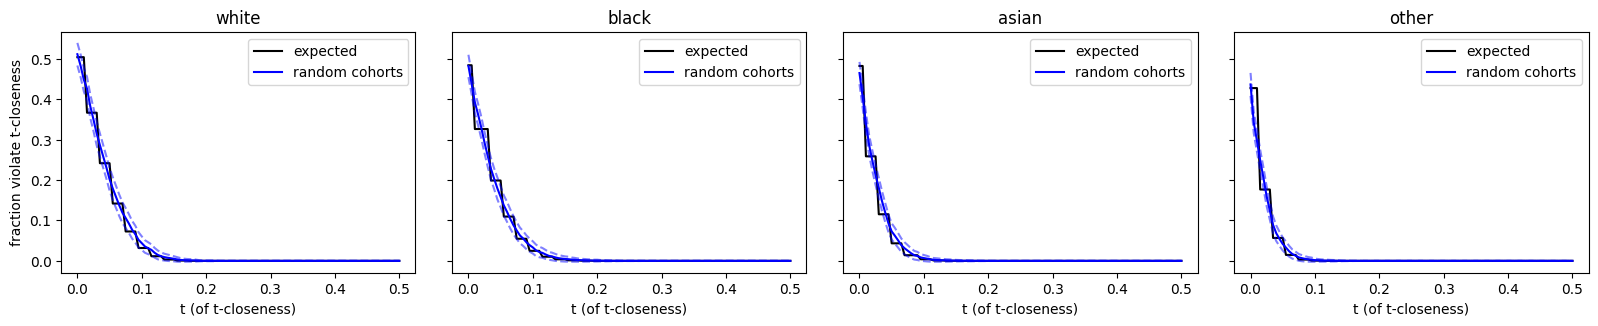

In [36]:
df = agg_t_closeness_random_cohorts_df

fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
plt.tight_layout()
for i, race in enumerate(['white','black','asian','other']):
    ax = axes[i]
    expected = est_t_violations_df[race]
    ax.plot(expected, label='expected', color='black')
    
    random_cohorts_mean = df[df['race']==race].set_index('t')['fraction_violate']
    ax.plot(random_cohorts_mean, label='random cohorts', color='blue')
    # plot confidence intervals
    random_cohorts_upper = df[df['race']==race].set_index('t')['upper']
    random_cohorts_lower = df[df['race']==race].set_index('t')['lower']
    ax.plot(random_cohorts_upper, '--', color='blue', alpha=0.5)
    ax.plot(random_cohorts_lower, '--', color='blue', alpha=0.5)

    ax.set_title(race)
    ax.set_xlabel('t (of t-closeness)')
    ax.legend()

_ = axes[0].set_ylabel('fraction violate t-closeness')

The expected values based on the binomial distribution closely match the empirical data for the randomly assigned cohorts data.

We use this as validation that we can use the binomial distribution CDF to estimate expected t-closeness violations.

Look at 'any' category violation.

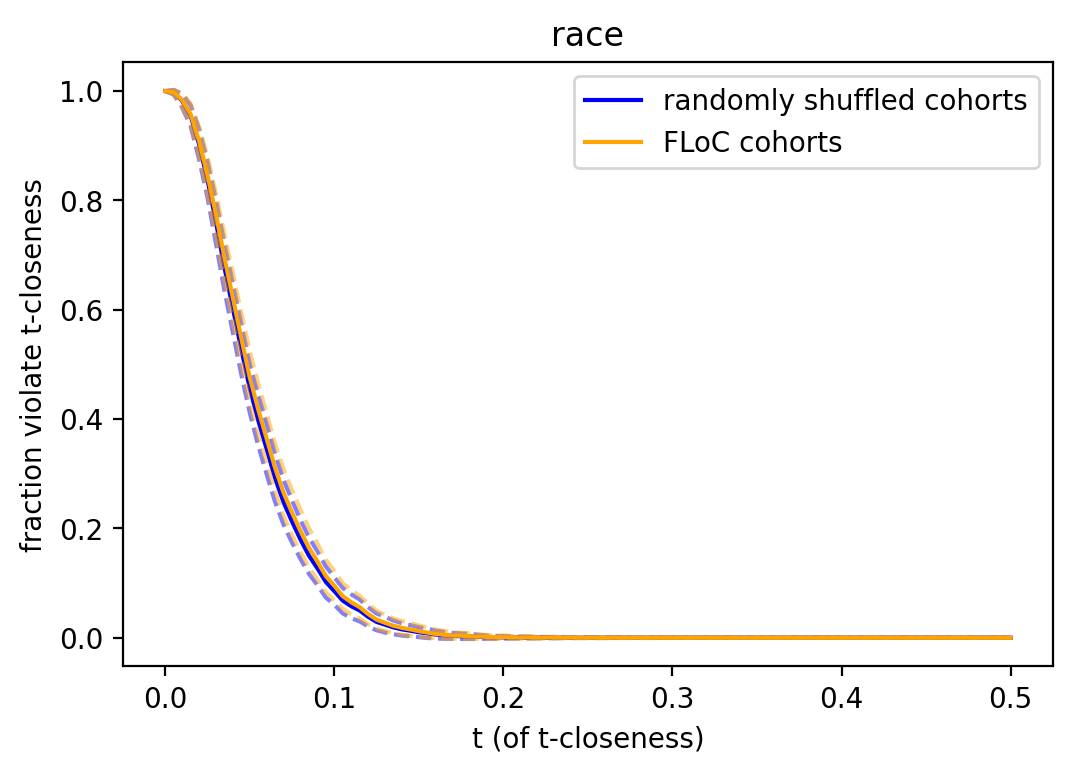

In [37]:
dpi=200
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=dpi, sharey=True)

race = 'any'

labeled_dfs = [
    # (label, color, df)
    ('randomly shuffled cohorts', 'blue', agg_t_closeness_random_cohorts_df),
    ('FLoC cohorts', 'orange', agg_t_closeness_df)
]
for (label, color, df) in labeled_dfs:

    mean = df[df['race']==race].set_index('t')['fraction_violate']
    ax.plot(mean, label=label, color=color)
    # plot confidence intervals
    upper = df[df['race']==race].set_index('t')['upper']
    lower = df[df['race']==race].set_index('t')['lower']
    ax.plot(upper, '--', alpha=0.5, color=color)
    ax.plot(lower, '--', alpha=0.5, color=color)

    ax.set_title('race')
    ax.set_xlabel('t (of t-closeness)')
    ax.legend()

_ = ax.set_ylabel('fraction violate t-closeness')

The t-closeness violations for the FLoC cohorts data fall within the CI's for the randomly shuffled cohorts data.